In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import swifter
from IPython.display import clear_output

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

prefix = 'pickle'

In [2]:
!ls -larth preprocess*

-rw-r--r--  1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@ 1 bono  staff   1.9G Apr  4 09:19 preprocessed.gemma9b.crippled.pickle
-rw-r--r--@ 1 bono  staff   1.6G Apr 30 10:20 preprocessed.pickle


In [3]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']
model_name = mydict['model_name']
model_name_short = model_name.split('/')[-1].lower()

In [4]:
model_name

'osunlp/TableLlama'

In [5]:
(m['shape'].sum() * 4) / (1024**3)

0.2360181100666523

In [6]:
m[m.run==0].groupby('pid').shape.sum().mean()

46596.49371766445

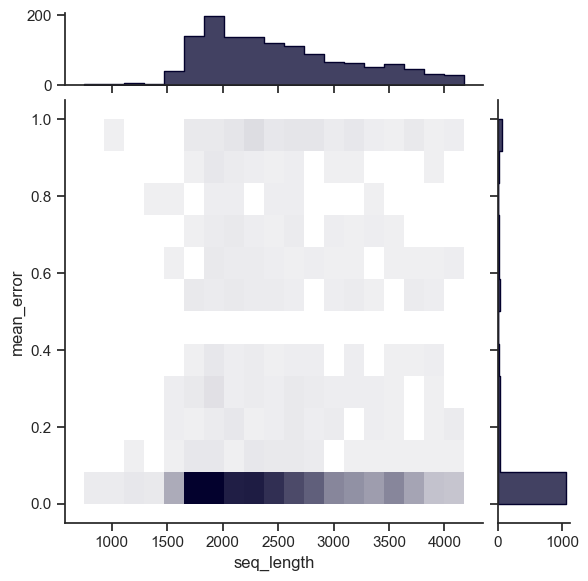

In [7]:
# sequence length vs correctness (check)

test = pd.DataFrame({'seq_length' : segments[segments.run==0].groupby('pid').length.sum(),
              'mean_error' : 1-truth.groupby('pid').correct.mean()})

import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=test, x='seq_length', y='mean_error', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [8]:
truth.groupby('pid').correct.mean().value_counts()

correct
1.0    1069
0.0      60
0.7      36
0.9      35
0.8      30
0.5      30
0.4      23
0.6      22
0.3      20
0.1      17
0.2      11
Name: count, dtype: int64

In [9]:
minrun = answers.run.max()
minrun

9

In [10]:
segments.groupby('pid').end.max().mean()

2511.7257945306724

In [11]:
gen = segments[segments.segment=='generated']
gen['length'] = gen.end - gen.start

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/3135544532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen['length'] = gen.end - gen.start


In [12]:
gen.groupby('pid').length.max().mean()

24.69549150036955

<Axes: xlabel='correct', ylabel='Count'>

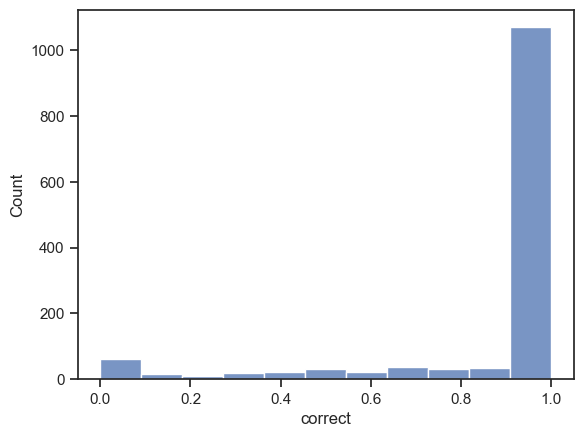

In [13]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

In [14]:
corec[(corec!=1.) & (corec!=0.)].shape[0] / corec.shape[0]

0.1655580192165558

In [15]:
# model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [17]:
# load questions

file_path = "turl_test_2k_prompts_50_unique.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [18]:
%%time

# tokenize inputs

tokenized = []

for idx, p in enumerate(prompts):
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt")
    p['pid'] = idx
    p['prompt'] = prompt
    p['tokenized'] = inputs
    tokenized.append(p)

Token indices sequence length is longer than the specified maximum sequence length for this model (8230 > 8192). Running this sequence through the model will result in indexing errors


CPU times: user 13.8 s, sys: 242 ms, total: 14 s
Wall time: 14.2 s


In [19]:
%%time

prompt_lenghts = []

for p in tokenized:
    plen = p['tokenized']['input_ids'][0].shape[0]
    
    cand_len = len(p['question'].split('>,')) - 1
    
    # TODO: check this! (some misalignment can occur )
    cand_pos = [idx for idx, cand in enumerate(p['question'].split('>,')) if p['output'] in cand + '>']
    
    # extract candidates
    candidates = p['question'].split(',. What')[0].split('<')[1:]
    candidates = [c.replace('>,', '').replace('>', '') for c in candidates]
    
    candidates_clean = [c.replace('[DESCRIPTION] ', '').replace('[DESC] ', '').replace('[TYPE] ', '').lower() for c in candidates]
    candidates_clean = [c for c in candidates_clean if c]
    
    candidates_clean_seq = [tokenizer(c, return_tensors="pt")['input_ids'].tolist()[0] for c in candidates_clean]
    
    prompt_lenghts.append((p['pid'], len(p['prompt']), plen, cand_len, cand_pos, candidates, candidates_clean, candidates_clean_seq))

pl = pd.DataFrame(prompt_lenghts, columns=['pid', 'char_len', 'tok_len', 'cand_len', 'cand_pos', 'cand', 'cand_clean', 'cand_clean_seq'])
pl['cand_pos_first'] = pl.cand_pos.str[0]

CPU times: user 7.76 s, sys: 122 ms, total: 7.89 s
Wall time: 7.97 s


In [20]:
pl

,pid,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first
0,0,5862,2020,47,[18],"[Murni Discovery Kelana Jaya [DESC] restaurant in Petaling, Selangor, Malaysia [TYPE] restaurant, Templat:S-line/Rel RapidKL...","[murni discovery kelana jaya restaurant in petaling, selangor, malaysia restaurant, templat:s-line/rel rapidkl right/laluan ...","[[1, 286, 595, 29875, 20699, 413, 295, 1648, 432, 9010, 27144, 297, 5697, 12818, 29892, 5535, 574, 272, 29892, 4439, 1036, 4...",18
1,1,6252,1959,49,[42],"[nakfa [DESC] currency of Eritrea [TYPE] currency, Coastal Eritrea [DESC] None [TYPE] None, Template:Regions of Eritrea [DES...","[nakfa currency of eritrea currency, coastal eritrea none none, template:regions of eritrea wikimedia template wikimedia tem...","[[1, 23349, 5444, 27550, 310, 604, 277, 5638, 27550], [1, 12180, 284, 604, 277, 5638, 5642, 5642], [1, 4472, 29901, 1727, 10...",42
2,2,7082,2340,48,[20],[David R. Macdonald Papers (NAID 649130) [DESC] collection in the National Archives and Records Administration's holdings [T...,[david r. macdonald papers (naid 649130) collection in the national archives and records administration's holdings collectio...,"[[1, 13260, 333, 364, 29889, 5825, 9176, 2741, 15055, 313, 1056, 333, 29871, 29953, 29946, 29929, 29896, 29941, 29900, 29897...",20
3,3,8320,2800,48,[28],"[Santa Inés [DESC] None [TYPE] None, Antonio Delfino [DESC] Wikimedia list article [TYPE] cargo liner, Delfino [DESC] attack...","[santa inés none none, antonio delfino wikimedia list article cargo liner, delfino attack submarine attack submarine, doña i...","[[1, 269, 6949, 297, 743, 5642, 5642], [1, 385, 880, 601, 628, 29888, 1789, 281, 638, 3393, 1051, 4274, 17040, 301, 4983], [...",28
4,4,5769,1930,48,[17],"[The Ink Pots [DESC] None [TYPE] painting, Pots Lake [DESC] lake in Oscoda County, Michigan, United States of America [TYPE]...","[the ink pots none painting, pots lake lake in oscoda county, michigan, united states of america lake, cream pots location i...","[[1, 278, 297, 29895, 282, 1862, 5642, 20413], [1, 282, 1862, 19437, 19437, 297, 15199, 8887, 15178, 29892, 21488, 11163, 29...",17
...,...,...,...,...,...,...,...,...,...
1796,1796,11209,4547,49,[36],"[Leda [DESC] mythical character [TYPE] mythological Greek character, Charis [DESC] given name [TYPE] unisex given name, Eudo...","[leda mythical character mythological greek character, charis given name unisex given name, eudoros greek mythical character...","[[1, 454, 1388, 22082, 936, 2931, 22082, 5996, 330, 7285, 2931], [1, 1373, 275, 2183, 1024, 443, 275, 735, 2183, 1024], [1, ...",36
1797,1797,19295,5372,51,[31],[The Supernova 1987A Shows a Mind of Its Own--and a Burst of Neutrinos: The first nearby supernova in 400 years continues to...,[the supernova 1987a shows a mind of its own--and a burst of neutrinos: the first nearby supernova in 400 years continues to...,"[[1, 278, 2428, 29876, 4273, 29871, 29896, 29929, 29947, 29955, 29874, 3697, 263, 3458, 310, 967, 1914, 489, 392, 263, 20887...",31
1798,1798,11485,2888,49,[0],"[Tocumen International Airport [DESC] international airport in Panama City, Panama [TYPE] airport, El Dorado Springs Memoria...","[tocumen international airport international airport in panama city, panama airport, el dorado springs memorial airport airp...","[[1, 304, 29883, 14170, 6121, 4799, 637, 6121, 4799, 637, 297, 7243, 3304, 4272, 29892, 7243, 3304, 4799, 637], [1, 560, 166...",0
1799,1799,10637,2716,48,[47],"[Gardiner [DESC] container ship built in 2003 [TYPE] container ship, Cape Town Stadium [DESC] sports stadium in Cape Town, S...","[gardiner container ship built in 2003 container ship, cape town stadium sports stadium in cape town, south africa multi-pur...","[[1, 17161, 4983, 5639, 7751, 4240, 297, 29871, 29906, 29900, 29900, 29941, 5639, 7751], [1, 274, 4085, 4726, 10728, 1974, 1...",47


In [21]:
pl.cand_len

0       47
1       49
2       48
3       48
4       48
        ..
1796    49
1797    51
1798    49
1799    48
1800    48
Name: cand_len, Length: 1801, dtype: int64

In [22]:
deb_ = pl.cand.str.len() == pl.cand_clean.str.len()


In [23]:
def cleanone(string):
    if not string: return None
    return string.replace('[DESCRIPTION]', '[DESC]').replace('<', '').replace('>', '').lower()

a = answers.merge(pl, on='pid', how='left')
a['reconstructed'] = a.apply(lambda row: row['cand'][row['cand_pos_first']], axis=1)

a['reconstructed_correct'] = (a.answer.str.replace('[DESCRIPTION]', '[DESC]').str.lower() == a.reconstructed.str.lower())
a['correct'] = (a.answer.apply(cleanone) == a.right_answer.apply(cleanone))


In [24]:
deb = a.merge(truth, on=['run', 'pid'])

In [25]:
deb['cand_present'] = deb.apply(lambda row: any([el.lower() == (row['answer'] or '').lower() for el in row['cand_clean']]), axis=1)

In [26]:
# TODO debug di questi casi residuali in cui la ricostruzione del candidato non coincide con 'truth' importato
# (validato in preprocess)

# x è la ricostruzione, y è nella for the rigenera tutto (truth)
deb[(deb.reconstructed_correct != deb.correct_y)]

,run,pid,answer,answer_seq,right_answer,regex_match,original_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct_x,correct_y,hallucinated,loosely_correct,cand_present
270,0,357,"fc barcelona [desc] association football club in barcelona, spain [type] association football team","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<fc barcelona [desc] association football club in barcelona, spain [type] association football team>","fc barcelona [desc] association football club in barcelona, spain [type] association football team","fc barcelona [desc] association football club in barcelona, spain [type] association football team",6158,1748,48,[48],"[Barcelona [DESC] Parliament of Catalonia constituency [TYPE] electoral district of the Parliament of Catalonia, FC Barcelon...","[barcelona parliament of catalonia constituency electoral district of the parliament of catalonia, fc barcelona atlètic span...","[[1, 2594, 2242, 2681, 22765, 310, 17246, 6405, 10719, 3819, 3546, 11251, 6474, 310, 278, 22765, 310, 17246, 6405], [1, 285,...",48,"FC Barcelona [DESC] association football club in Barcelona, Spain [TYPE] association football team. What is the correct refe...",False,True,True,False,True,False
271,1,357,"fc barcelona [desc] association football club in barcelona, spain [type] association football team","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<fc barcelona [desc] association football club in barcelona, spain [type] association football team>","fc barcelona [desc] association football club in barcelona, spain [type] association football team","fc barcelona [desc] association football club in barcelona, spain [type] association football team",6158,1748,48,[48],"[Barcelona [DESC] Parliament of Catalonia constituency [TYPE] electoral district of the Parliament of Catalonia, FC Barcelon...","[barcelona parliament of catalonia constituency electoral district of the parliament of catalonia, fc barcelona atlètic span...","[[1, 2594, 2242, 2681, 22765, 310, 17246, 6405, 10719, 3819, 3546, 11251, 6474, 310, 278, 22765, 310, 17246, 6405], [1, 285,...",48,"FC Barcelona [DESC] association football club in Barcelona, Spain [TYPE] association football team. What is the correct refe...",False,True,True,False,True,False
272,2,357,"fc barcelona [desc] association football club in barcelona, spain [type] association football team","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<fc barcelona [desc] association football club in barcelona, spain [type] association football team>","fc barcelona [desc] association football club in barcelona, spain [type] association football team","fc barcelona [desc] association football club in barcelona, spain [type] association football team",6158,1748,48,[48],"[Barcelona [DESC] Parliament of Catalonia constituency [TYPE] electoral district of the Parliament of Catalonia, FC Barcelon...","[barcelona parliament of catalonia constituency electoral district of the parliament of catalonia, fc barcelona atlètic span...","[[1, 2594, 2242, 2681, 22765, 310, 17246, 6405, 10719, 3819, 3546, 11251, 6474, 310, 278, 22765, 310, 17246, 6405], [1, 285,...",48,"FC Barcelona [DESC] association football club in Barcelona, Spain [TYPE] association football team. What is the correct refe...",False,True,True,False,True,False
273,3,357,"fc barcelona [desc] association football club in barcelona, spain [type] association football team","[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...","<fc barcelona [desc] association football club in barcelona, spain [type] association football team>","fc barcelona [desc] association football club in

In [27]:
deb_[deb_==False]

38      False
108     False
158     False
222     False
505     False
588     False
1006    False
1119    False
1252    False
1302    False
1545    False
1606    False
1719    False
1768    False
1770    False
dtype: bool

In [28]:
# TODO alcuni sono dovuti a disallineamento della lista cand_len (omissione durante pulizia!)
deb[(deb.reconstructed_correct != deb.correct_y)].pid.unique()

array([ 357,  748, 1042, 1473,  229, 1327, 1082,  124, 1179,  973, 1084,
        136, 1719, 1634, 1016, 1684, 1085,  620, 1765, 1019,  146, 1545,
        435, 1606,  241, 1119, 1556,   16,  250, 1516, 1252,  108,  604,
        527,   36])

In [29]:
mypid = 217
candlist = deb[deb.pid==mypid].drop_duplicates('pid').iloc[0].cand
candlist_clean = deb[deb.pid==mypid].drop_duplicates('pid').iloc[0].cand_clean

len(candlist), len(candlist_clean)

(50, 50)

In [30]:
deb[(deb.correct_x != deb.correct_y)][['answer', 'reconstructed', 'right_answer', 'correct_x', 'correct_y']]

,answer,reconstructed,right_answer,correct_x,correct_y


In [31]:
# allucinazioni
deb[(~deb.cand_present) & (deb.hallucinated)]

,run,pid,answer,answer_seq,right_answer,regex_match,original_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct_x,correct_y,hallucinated,loosely_correct,cand_present
1010,0,1376,2010–11 uefa champions league [desc] 56th season of the uefa club football tournament [type] sports season,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<uefa champions league 2010-11 [desc] 56th season of the uefa club football tournament [type] sports season>,2010–11 uefa champions league [desc] 56th season of the uefa club football tournament [type] sports season,2010–11 uefa champions league [desc] 56th season of the uefa club football tournament [type] sports season,6229,1802,42,[22],"[2009–10 UEFA Champions League [DESC] 55th season of the UEFA club football tournament [TYPE] sports season, 1993–94 UEFA Ch...","[2009–10 uefa champions league 55th season of the uefa club football tournament sports season, 1993–94 uefa champions league...","[[1, 29871, 29906, 29900, 29900, 29929, 29994, 29896, 29900, 318, 1389, 29874, 29314, 13225, 29871, 29945, 29945, 386, 4259,...",22,UEFA Champions League 2010-11 [DESC] 56th season of the UEFA club football tournament [TYPE] sports season,False,False,False,True,False,False
1018,8,1376,2010–11 uefa champions league [desc] 56th season of the uefa club football tournament [type] sports season,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<uefa champions league 2010-11 [desc] 56th season of the uefa club football tournament [type] sports season>,2010–11 uefa champions league [desc] 56th season of the uefa club football tournament [type] sports season,2010–11 uefa champions league [desc] 56th season of the uefa club football tournament [type] sports season,6229,1802,42,[22],"[2009–10 UEFA Champions League [DESC] 55th season of the UEFA club football tournament [TYPE] sports season, 1993–94 UEFA Ch...","[2009–10 uefa champions league 55th season of the uefa club football tournament sports season, 1993–94 uefa champions league...","[[1, 29871, 29906, 29900, 29900, 29929, 29994, 29896, 29900, 318, 1389, 29874, 29314, 13225, 29871, 29945, 29945, 386, 4259,...",22,UEFA Champions League 2010-11 [DESC] 56th season of the UEFA club football tournament [TYPE] sports season,False,False,False,True,False,False
2481,1,229,union of democratic forces [desc] political party in bulgaria [type] political party,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<union of democratic forces [desc] political party [type] political party in bulgaria>,union of democratic forces [desc] political party in bulgaria [type] political party,union of democratic forces [desc] political party in bulgaria [type] political party,10140,2971,49,[49],"[Civic Democratic Union [DESC] political party in Slovakia [TYPE] political party, Chadian Democratic Union [DESC] Chad poli...","[civic democratic union political party in slovakia political party, chadian democratic union chad political party (1990–) p...","[[1, 14175, 293, 1261, 8415, 2454, 9833, 8604, 6263, 297, 25007, 557, 423, 8604, 6263], [1, 521, 328, 713, 1261, 8415, 2454,...",49,Union of Democratic Forces [DESC] political party [TYPE] political party in Bulgaria. What is the correct referent entity fo...,False,False,False,True,False,False
2482,2,229,union of democratic forces [desc] political party in bulgaria [type] political party,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<union of democratic forces [desc] political party [type] political party in bulgaria>,union of democratic forces [desc] political party in bulgaria [type] political party,union of democratic forces [desc] political par

In [32]:
def cleanup_before_she_comes(mystr):
    if not mystr: return None
    mystr = mystr.lower().replace('[desc] ', '').replace('[description] ', '').replace('[type] ', '')
    # if ']' in mystr or '[' in mystr: print(mystr)
    return mystr

a['answer_clean'] = a.answer.apply(lambda x: cleanup_before_she_comes(x)).str.replace('<', '').str.replace('>', '')
a['right_answer_clean'] = a['right_answer'].str.replace('[description] ', '').str.replace('[desc] ', '').str.replace('[type] ', '').str.replace('<', '').str.replace('>', '')


In [33]:
a

,run,pid,answer,answer_seq,right_answer,regex_match,original_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct,answer_clean,right_answer_clean
0,0,1676,washington commanders [desc] american football team in the national football league [type] american football team,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<washington commanders [desc] american football team in the national football league [type] american football team>,washington commanders [desc] american football team in the national football league [type] american football team,washington commanders [desc] american football team in the national football league [type] american football team,8422,2887,49,[30],"[Template:Super Bowl LIV [DESC] Wikimedia template [TYPE] Wikimedia template, Template:Super Bowl IX [DESC] Wikimedia templa...","[template:super bowl liv wikimedia template wikimedia template, template:super bowl ix wikimedia template wikimedia template...","[[1, 4472, 29901, 9136, 12580, 29880, 7294, 281, 638, 3393, 4472, 281, 638, 3393, 4472], [1, 4472, 29901, 9136, 12580, 29880...",30,Washington Commanders [DESC] American football team in the National Football League [TYPE] American football team,True,True,washington commanders american football team in the national football league american football team,washington commanders american football team in the national football league american football team
1,1,1676,washington commanders [desc] american football team in the national football league [type] american football team,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<washington commanders [desc] american football team in the national football league [type] american football team>,washington commanders [desc] american football team in the national football league [type] american football team,washington commanders [desc] american football team in the national football league [type] american football team,8422,2887,49,[30],"[Template:Super Bowl LIV [DESC] Wikimedia template [TYPE] Wikimedia template, Template:Super Bowl IX [DESC] Wikimedia templa...","[template:super bowl liv wikimedia template wikimedia template, template:super bowl ix wikimedia template wikimedia template...","[[1, 4472, 29901, 9136, 12580, 29880, 7294, 281, 638, 3393, 4472, 281, 638, 3393, 4472], [1, 4472, 29901, 9136, 12580, 29880...",30,Washington Commanders [DESC] American football team in the National Football League [TYPE] American football team,True,True,washington commanders american football team in the national football league american football team,washington commanders american football team in the national football league american football team
2,2,1676,washington commanders [desc] american football team in the national football league [type] american football team,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29892, 3300, 2859, 411, 385, 1881, 393, 8128, 4340, 3030, 29889, 14350, ...",<washington commanders [desc] american football team in the national football league [type] american football team>,washington commanders [desc] american football team in the national football league [type] american football team,washington commanders [desc] american football team in the national football league [type] american football team,8422,2887,49,[30],"[Template:Super Bowl LIV [DESC] Wikimedia template [TYPE] Wikimedia template, Template:Super Bowl IX [DESC] Wikimedia templa...","[template:super bowl liv wikimedia template wikimedia template, template:super bowl ix wikimedia template wikimedia template...","[[1, 4472, 29901, 9136, 12580, 29880, 7294, 281, 638, 3393, 4472, 281, 638, 3393, 4472], [1, 4472, 29901, 9136, 12580, 29880...",30,Washington Commanders [DESC] American football team in the National Football League [TYPE] American foo

### distance among correct candidate and all candidates

In [34]:
from sentence_transformers import SentenceTransformer

device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2").to(device)


In [35]:
%%time

# do not compute the same embeddings many times
mycache = {}
myanscache = {}

if True:
    cc_ = []
    allc_ = []
    ans_ = []

    for row in a.itertuples():
        clear_output(wait=True)
        print(row.run, row.pid, end='\r')
        cc = row.right_answer_clean
        allc = row.cand_clean

        allc_tuple = tuple(allc)
        if (cc, allc_tuple) in mycache:
            (cc_embeddings, allc_embeddings) = mycache[(cc, allc_tuple)]
        else:
            cc_embeddings = model.encode([cc])
            allc_embeddings = model.encode(allc)
            mycache[(cc, allc_tuple)] = (cc_embeddings, allc_embeddings)    
        cc_.append(cc_embeddings)
        allc_.append(allc_embeddings)
            
        ans = row.answer_clean    
        if ans in myanscache:
            ans_embeddings = myanscache[ans]
        else:
            ans_embeddings = model.encode([ans])
            myanscache[ans] = ans_embeddings 
        ans_.append(ans_embeddings)
        

    a['right_answer_clean_embedding'] = cc_
    a['cand_clean_embedding'] = allc_
    a['answer_clean_embedding'] = ans_
    
    import pickle
    with open('cohesion.pickle', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 4min 58s, sys: 1min 36s, total: 6min 35s
Wall time: 3min 58s


In [36]:
with open('cohesion.pickle', 'rb') as handle:
        a = pickle.load(handle)

In [37]:
a.shape, a[a.cand_len>=10].shape

((13530, 23), (13470, 23))

In [38]:
a.shape, a[a.cand_len>=10].shape

((13530, 23), (13470, 23))

In [39]:
# at least 10 candidates
a = a[a.cand_len>=10]

In [40]:
%%time

# extract cosine similarities among right candidate and all candidates (cold measure)
from sentence_transformers.util import cos_sim
a['cos_sim_right_cand'] = a.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['cand_clean_embedding']), axis=1)

CPU times: user 5.95 s, sys: 2.36 s, total: 8.31 s
Wall time: 1.19 s


In [41]:
# tensor to list
a['cos_sim_right_cand'] = a.apply(lambda x: x['cos_sim_right_cand'].tolist()[0], axis=1)

In [42]:
# check max sim is always self
a['cos_sim_right_cand'].apply(lambda x: max(x))

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
13525    1.0
13526    1.0
13527    1.0
13528    1.0
13529    1.0
Name: cos_sim_right_cand, Length: 13470, dtype: float64

In [43]:
# min candidates
a.apply(lambda x: len(x.cos_sim_right_cand), axis=1).min()

11

In [44]:
a.loc[0]['cand_clean_embedding'].shape

(50, 768)

In [45]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

def cosine_distance_stats(embeddings):
    D = pairwise_distances(embeddings, metric="cosine")
    triu_indices = np.triu_indices_from(D, k=1)  # upper triangular indices without diagonal
    distances = D[triu_indices]
    return (np.mean(distances), np.min(distances), np.max(distances), np.var(distances))

# gini ~ 0 -> uniform distances -> high cohesion
# gini ~ 1 -> variable distances -> low cohesion
def gini_coefficient(embeddings):
    D = pairwise_distances(embeddings, metric="cosine")
    triu_indices = np.triu_indices_from(D, k=1)  # upper triangular indices without diagonal
    distances = np.sort(D[triu_indices])  # sort
    n = len(distances)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)  # index array
    return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index

import scipy.spatial
import scipy.linalg

def spectral_gap(embeddings):   
    try:
        # spectral gap (λ2) of the graph Laplacian from a distance matrix
        D = pairwise_distances(embeddings, metric="cosine")

        # distances to similarities
        sigma = np.median(D)  # scale
        W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix

        # Laplacian
        D_matrix = np.diag(W.sum(axis=1))
        L = D_matrix - W  # graph laplacian

        # eigenvalues
        eigenvalues = np.linalg.eigvalsh(L)
        return np.sort(eigenvalues)[1]  # second smallest eigenvalue is the spectral gap
    except Exception as e:
        return None

In [46]:
import numpy as np
import itertools

def jaccard_similarity(list1, list2):
    intersection = len(set(list1) & set(list2))
    union = len(set(list1)) + len(set(list2)) - intersection
    return float(intersection) / union if union != 0 else 0.0

def jaccard_upper_triangle(lists):
    n = len(lists)
    distances = []
    
    for i, j in itertools.combinations(range(n), 2):
        similarity = jaccard_similarity(lists[i], lists[j])
        distances.append(1 - similarity)

    return distances

def jaccard_distance_stats(mylist):
    if type(mylist[0]) == str: mylist = [l.split(' ') for l in mylist] # convert to list if string
    distances = jaccard_upper_triangle(mylist)
    return (np.mean(distances), np.min(distances), np.max(distances), np.var(distances))


In [47]:
%%time

# measures of consistency among candidates (also considering the right one)
# these measures are constant across runs (and can be used as input features)

# VRO w.r.t. correct answer 
a['right_cand_avg_dist'] = a.swifter.apply(lambda x: 1. - (sum(x.cos_sim_right_cand) - 1.) / (len(x.cos_sim_right_cand) - 1), axis=1)

# distance from the nearest
a['right_cand_mindist'] = a.swifter.apply(lambda x: 1. - x.cos_sim_right_cand[np.argpartition(x.cos_sim_right_cand, -2)[-2]], axis=1) # second largest distance

# distance matrix stats
a[['cand_average_dist','cand_min_dist','cand_max_dist','cand_variance_of_dist']] = a.swifter.apply(lambda x: cosine_distance_stats(x.cand_clean_embedding), axis=1, result_type='expand') 

# jaccard on words and tokens
a[['cand_average_jaccard_dist','cand_min_jaccard_dist','cand_max_jaccard_dist','cand_variance_of_jaccard_dist']] = a.swifter.apply(lambda x: jaccard_distance_stats(x.cand_clean), axis=1, result_type='expand') 
a[['cand_average_jaccard_tok_dist','cand_min_jaccard_tok_dist','cand_max_jaccard_tok_dist','cand_variance_of_jaccard_tok_dist']] = a.swifter.apply(lambda x: jaccard_distance_stats(x.cand_clean_seq), axis=1, result_type='expand') 

# gini coefficient
a['cand_gini_coef'] = a.swifter.apply(lambda x: gini_coefficient(x.cand_clean_embedding), axis=1) # gini coefficient

# spectral gap
a['cand_spectral_gap'] = a.swifter.apply(lambda x: spectral_gap(x.cand_clean_embedding), axis=1) # spectral gap


Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13470 [00:00<?, ?it/s]

CPU times: user 2min 35s, sys: 42.6 s, total: 3min 18s
Wall time: 1min 22s


In [48]:
# TODO debug these mofos (most probably broken candidates lists)
a[a['cand_spectral_gap'].isna()]

,run,pid,answer,answer_seq,right_answer,regex_match,original_answer,char_len,tok_len,cand_len,cand_pos,cand,cand_clean,cand_clean_seq,cand_pos_first,reconstructed,reconstructed_correct,correct,answer_clean,right_answer_clean,right_answer_clean_embedding,cand_clean_embedding,answer_clean_embedding,cos_sim_right_cand,right_cand_avg_dist,right_cand_mindist,cand_average_dist,cand_min_dist,cand_max_dist,cand_variance_of_dist,cand_average_jaccard_dist,cand_min_jaccard_dist,cand_max_jaccard_dist,cand_variance_of_jaccard_dist,cand_average_jaccard_tok_dist,cand_min_jaccard_tok_dist,cand_max_jaccard_tok_dist,cand_variance_of_jaccard_tok_dist,cand_gini_coef,cand_spectral_gap


In [49]:
a = a[~a['cand_spectral_gap'].isna()]

### candidate cohesion VS avg accuracy

In [50]:
# there is no variance here! drop_duplicates and keep='first' should give the very same result

aggro = a.groupby('pid').agg({'correct': 'mean', 
                              'right_cand_avg_dist': ['mean', 'std'], 
                              'right_cand_mindist': ['mean', 'std'],
                              'cand_variance_of_dist': ['mean', 'std'],
                              'cand_gini_coef': ['mean', 'std'],
                              'cand_spectral_gap': ['mean', 'std'],
                              'cand_average_dist': ['mean', 'std'],
                              'cand_min_dist': ['mean', 'std'],
                              'cand_max_dist': ['mean', 'std'],
                              'cand_variance_of_dist': ['mean', 'std'],
                              'cand_average_jaccard_dist': ['mean', 'std'],
                              'cand_min_jaccard_dist': ['mean', 'std'],
                              'cand_max_jaccard_dist': ['mean', 'std'],
                              'cand_variance_of_jaccard_dist': ['mean', 'std'],
                              'cand_average_jaccard_tok_dist': ['mean', 'std'],
                              'cand_min_jaccard_tok_dist': ['mean', 'std'],
                              'cand_max_jaccard_tok_dist': ['mean', 'std'],
                              'cand_variance_of_jaccard_tok_dist': ['mean', 'std']
                             })


In [51]:
aggro.columns = ['_'.join([str(c) for c in col]).strip() for col in aggro.columns.values]

In [52]:
# must be true (no variance on measures not supposed to vary)
aggro[[c for c in aggro.columns if c.endswith('_std')]].sum().sum() == 0.

True

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2516736992.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])


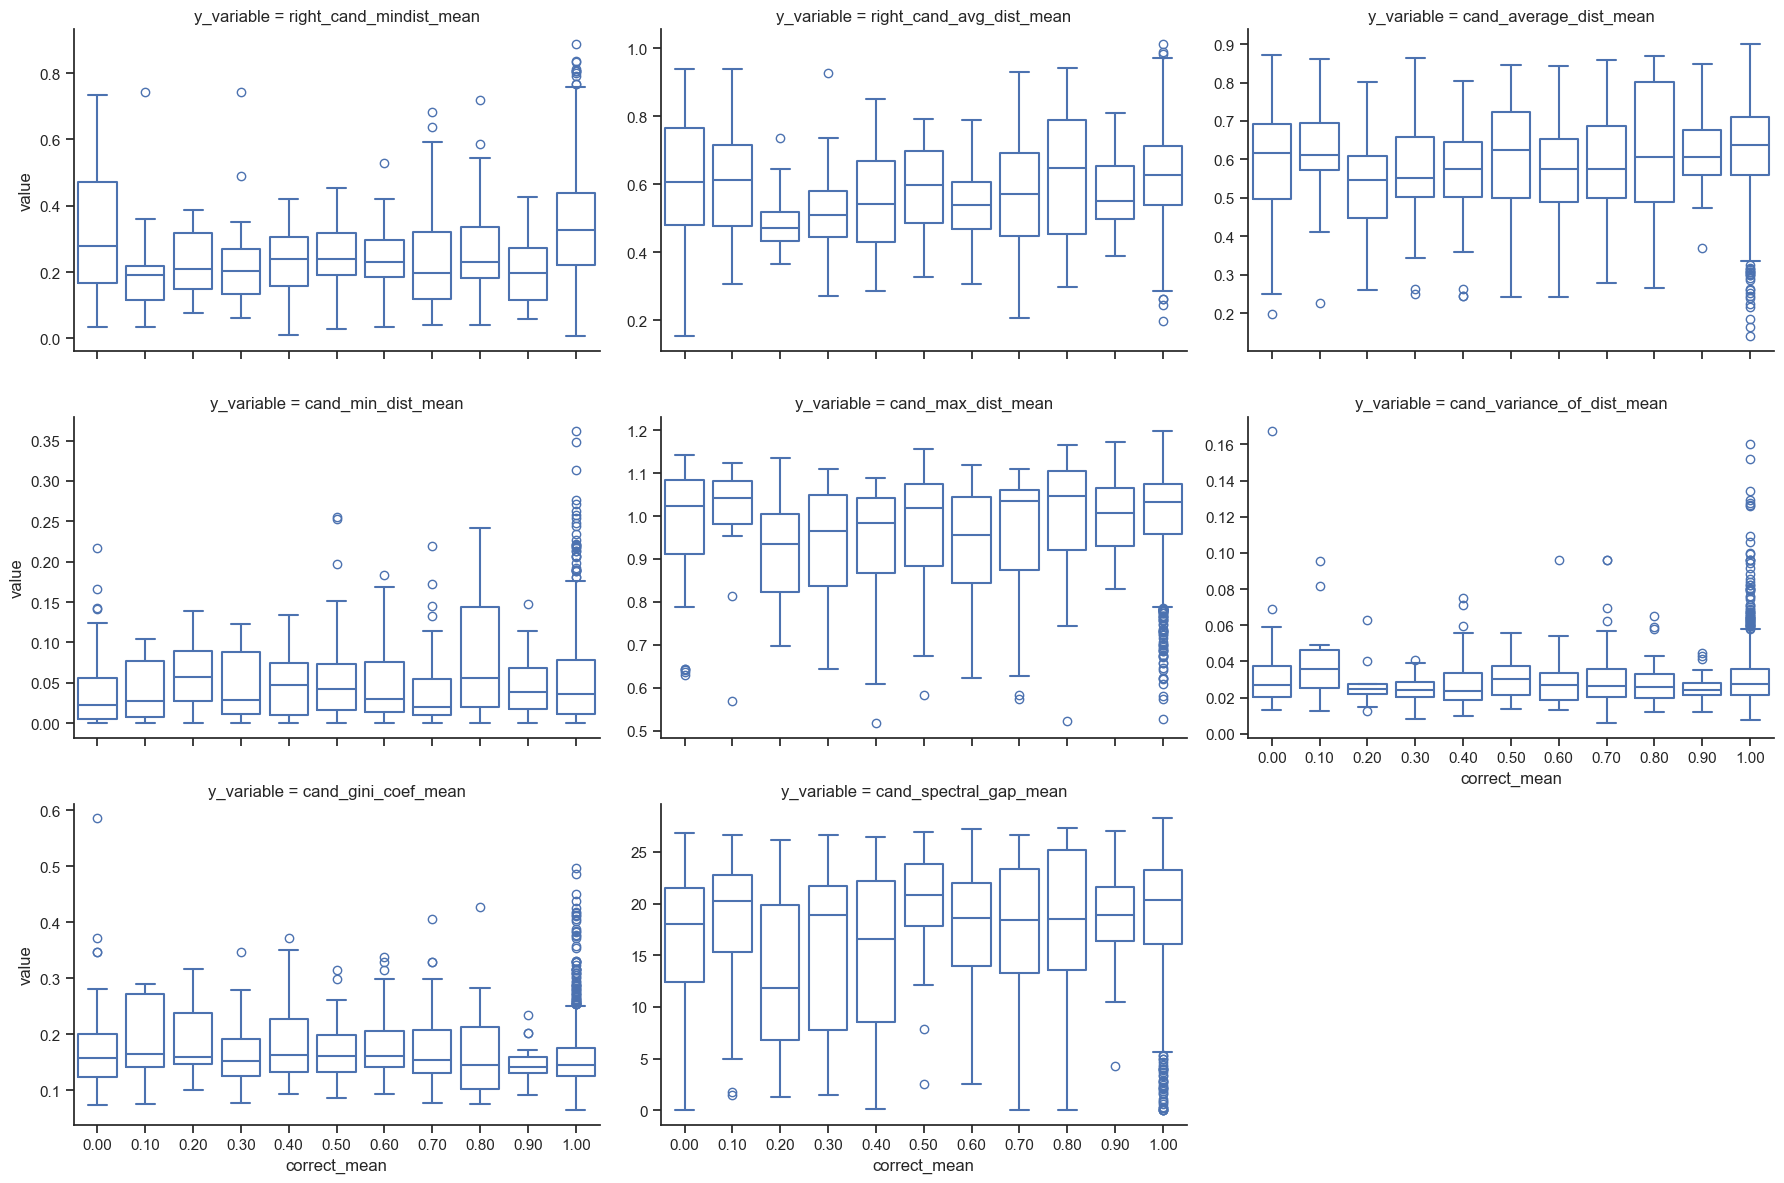

In [53]:

y_vars = ['right_cand_mindist_mean', 
          'right_cand_avg_dist_mean', 
          'cand_average_dist_mean',
          'cand_min_dist_mean',
          'cand_max_dist_mean',
          'cand_variance_of_dist_mean',
          'cand_gini_coef_mean',
          'cand_spectral_gap_mean']


# Reshape DataFrame to long format using `melt`
aggro_melted = aggro.melt(id_vars=["correct_mean"], value_vars=y_vars, 
                          var_name="y_variable", value_name="value")


# Create FacetGrid for multiple y-variables
g = sns.FacetGrid(aggro_melted, col="y_variable", height=4, aspect=1.5, 
                  sharex=True, sharey=False, col_wrap=3)

# Map plot to each facet
# g.map_dataframe(sns.violinplot, x="correct_mean", y="value", split=True, fill=False, inner="quart")
g.map_dataframe(sns.boxplot, x="correct_mean", y="value", fill=False)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.2f}"))
    ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])

<Axes: >

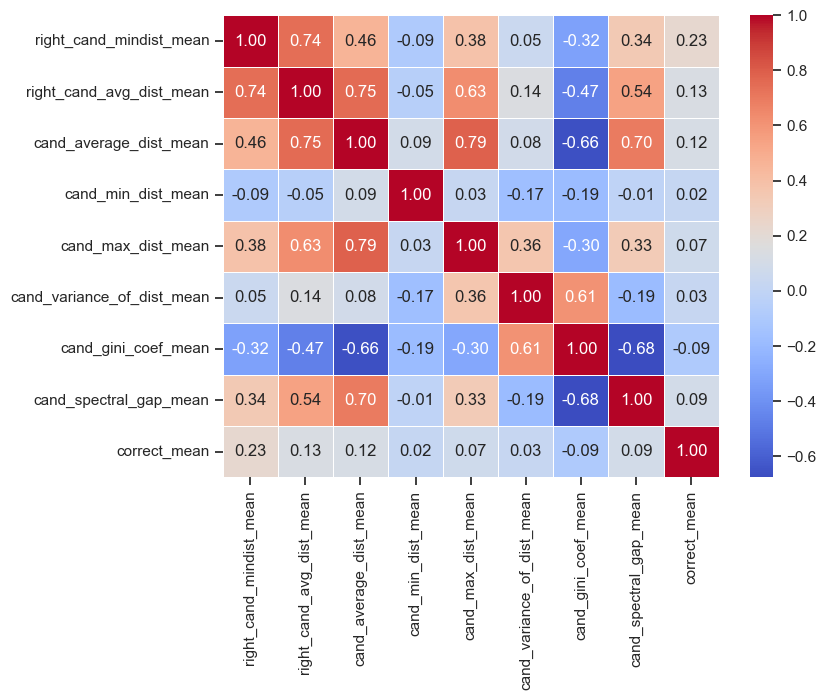

In [54]:
corr_matrix = aggro[['right_cand_mindist_mean', 
                     'right_cand_avg_dist_mean', 
                     'cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_gini_coef_mean',
                     'cand_spectral_gap_mean',
                     'correct_mean']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

<Axes: >

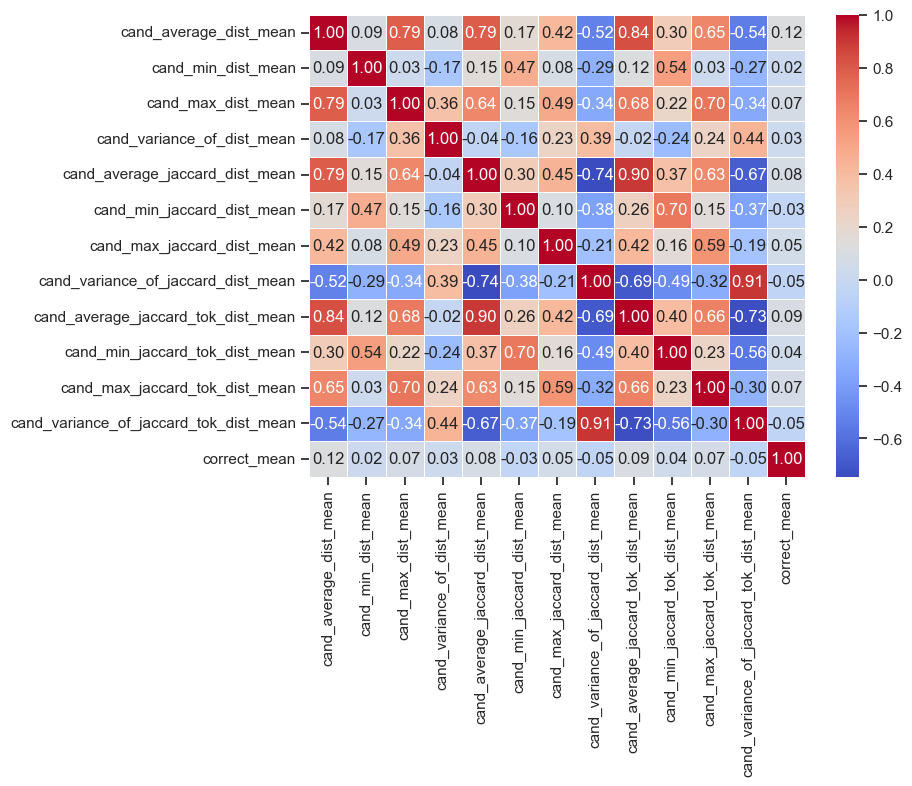

In [55]:
# distanze tra input (senza right candidate)

corr_matrix = aggro[['cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_average_jaccard_dist_mean',
                     'cand_min_jaccard_dist_mean',
                     'cand_max_jaccard_dist_mean',
                     'cand_variance_of_jaccard_dist_mean',
                     'cand_average_jaccard_tok_dist_mean',
                     'cand_min_jaccard_tok_dist_mean',
                     'cand_max_jaccard_tok_dist_mean',
                     'cand_variance_of_jaccard_tok_dist_mean',
                     'correct_mean'
]].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

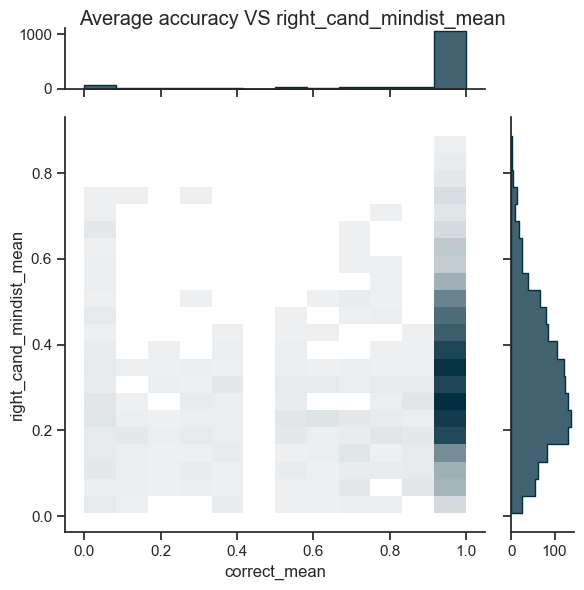

In [56]:
import seaborn as sns
sns.set_theme(style="ticks")

# most correlated
g = sns.JointGrid(data=aggro, x='correct_mean', y='right_cand_mindist_mean', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS right_cand_mindist_mean")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

In [57]:
# aggregate answer text and embeddings per each prompt
ac = a.groupby('pid')['answer_clean'].apply(list).reset_index()
ace = a.groupby('pid')['answer_clean_embedding'].apply(list).apply(lambda x: np.vstack(x)).reset_index()

# anwer sequences
a['answer_seq0'] = a.answer_seq.str[0]
ace2 = a.groupby('pid')['answer_seq0'].apply(list).reset_index()

# candidates
ace3 = a.groupby('pid')['cand_clean'].apply(lambda x: list(x)[0]).reset_index()

In [58]:
a.shape, ac.shape, ace.shape, ace2.shape

((13470, 41), (1347, 2), (1347, 2), (1347, 2))

In [59]:
ac = ac.merge(ace, on='pid').merge(ace2, on='pid').merge(ace3, on='pid').merge(a[['pid', 'right_answer_clean_embedding']].drop_duplicates('pid'), on='pid', how='left')

In [60]:
%%time

# these depend on knowing the right answer

# extract cosine similarities among right candidate and all outputted  answers
from sentence_transformers.util import cos_sim
ac['cos_sim_right_and_answers'] = ac.apply(lambda x: cos_sim(x['right_answer_clean_embedding'], x['answer_clean_embedding']), axis=1)
ac['cos_sim_right_and_answers'] = ac.apply(lambda x: x['cos_sim_right_and_answers'].tolist()[0], axis=1)

# measures of consistency among output values
ac['right_and_answers_avg_dist'] = ac.apply(lambda x: 1. - (sum(x.cos_sim_right_and_answers) - 1.) / (len(x.cos_sim_right_and_answers) - 1), axis=1)
# distance from the nearest
ac['right_and_answers_mindist'] = ac.apply(lambda x: 1. - x.cos_sim_right_and_answers[np.argpartition(x.cos_sim_right_and_answers, -2)[-2]], axis=1) # second largest distance

CPU times: user 97.7 ms, sys: 1.99 ms, total: 99.7 ms
Wall time: 77.4 ms


In [61]:
%%time

# distance matrix stats
ac[['answers_average_dist', 'answers_min_dist','answers_max_dist','answers_variance_of_dist']] = ac.apply(lambda x: cosine_distance_stats(x.answer_clean_embedding), axis=1, result_type='expand') 

# gini coefficient
ac['answers_gini_coef'] = ac.apply(lambda x: gini_coefficient(x.answer_clean_embedding), axis=1) # gini coefficient

ac['answers_spectral_gap'] = ac.apply(lambda x: spectral_gap(x.answer_clean_embedding), axis=1) # spectral gap

# number of answers (set measure)
ac['num_answers'] = ac.apply(lambda x: len(set(x.answer_clean)), axis=1)

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykern

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (2 * np.sum(index * distances) / (n * np.sum(distances))) - (n + 1) / n # gini index
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykern

CPU times: user 1.35 s, sys: 10.7 ms, total: 1.36 s
Wall time: 776 ms


/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:32: RuntimeWarning: divide by zero encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_27604/2752667182.py:32: RuntimeWarning: invalid value encountered in divide
  W = np.exp(-D ** 2 / (2 * sigma ** 2))  # similarity matrix
/var/folders/k

In [62]:
ac[['answers_average_jaccard_dist','answers_min_jaccard_dist','answers_max_jaccard_dist','answers_variance_of_jaccard_dist']] = ac.swifter.apply(lambda x: jaccard_distance_stats(x.answer_clean), axis=1, result_type='expand') 
ac[['answers_average_jaccard_tok_dist','answers_min_jaccard_tok_dist','answers_max_jaccard_tok_dist','answers_variance_of_jaccard_tok_dist']] = ac.swifter.apply(lambda x: jaccard_distance_stats(x.answer_seq0), axis=1, result_type='expand') 


Pandas Apply:   0%|          | 0/1347 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1347 [00:00<?, ?it/s]

In [63]:
# entropy of answers
from scipy.stats import entropy
from collections import Counter

ac['answers_freqs'] = ac.apply(lambda x: list(Counter(x.answer_clean).values()), axis = 1)
ac['answers_entropy'] = ac.apply(lambda x: entropy(x.answers_freqs), axis = 1)
ac['answers_entropy_norm'] = ac.apply(lambda x: x.answers_entropy / max(1, np.log2(len(x.answers_freqs))), axis = 1)

In [64]:
(ac.answers_freqs.str.len() == ac.num_answers).sum() == ac.shape[0]

True

### progressive answers

In [65]:
# recover generated start token in seq
ac = ac.merge(segments[segments.segment=='generated'][['pid', 'start']].drop_duplicates(), on='pid', how='left')

In [66]:
len(ac.iloc[0].answer_seq0[:2])

2

In [67]:
# tokens
# 518 [
# 29962 ]
# 29966 <
# 29958 >
# 2 <\s>
# 2287 7187 24290 2725 DE SC RIPT ION
# 2287 7187 DE SC
# 11116 TYPE

myfilter = set([518, 29962, 29966, 29958, 2, 11116])

def remove_sublist(lst, sub):
    i = 0
    out = []
    while i < len(lst):
        if lst[i:i+len(sub)] == sub:
            i += len(sub)
        else:
            out.append(lst[i])
            i += 1
    return out

# remove template tokens
def cleanup_before_she_comes_sequence(myseq):
    myseq = remove_sublist(myseq, [2287, 7187, 24290, 2725])
    myseq = remove_sublist(myseq, [2287, 7187])
    myseq = [m for m in myseq if m not in myfilter]
    
    return myseq

def cleanup_before_she_comes_redux(mystr):
    mystr = mystr.replace('DESCRIPTION', '').replace('DESC', '').replace('TYPE', '').replace('[', '').replace(']', '')
    mystr = ' '.join(mystr.split())
    return mystr

In [66]:
%%time
ac['answer_seq0_clean'] = ac.apply(lambda x: [cleanup_before_she_comes_sequence(s[x.start:]) for s in x.answer_seq0], axis=1)

NameError: name 'cleanup_before_she_comes_sequence' is not defined

In [69]:
# we replace all newlines since some nasty model (gemma 9b st least) have some fantasy

#[':\n<Gilbert Acland-Troyte [DESC] Soldier, politician (1876-1964) [TYPE] human> \n\n\n',
# ':\n<Gilbert Acland-Troyte [DESC] Soldier, politician (1876-1964) [TYPE] human> \n\n\n\n',
# ':\n<Gilbert Acland-Troyte [DESC] Soldier, politician (1876-1964) [TYPE] human>\n\n\n',
# ':\n<Gilbert Acland-Troyte [DESC] Soldier, politician (1876-1964) [TYPE] human> \n',
# ':\n<Gilbert Acland-Troyte [DESC] Soldier, politician (1876-1964) [TYPE] human>',

In [70]:
%%time

# for each max token, for each number of runs, extract answers entropy

runs = ac.answer_seq0.str.len().max()
MAXTOK = 14

mout = []

for tok in range(1, MAXTOK + 1):
    for run in range (2, runs + 1):
        clear_output(wait=True)
        print(tok, run, end='\r')
        for item in ac.itertuples():
            
            seqs = item.answer_seq0_clean[:run] # how many runs
            subs = [tokenizer.decode(s[:tok], skip_special_tokens=True) for s in seqs]
            subs = [s.replace('\n', '').strip() for s in subs]
            subs_clean = subs # [cleanup_before_she_comes_redux(s) for s in subs]
            
            freqs = list(Counter(subs_clean).values())
            ent = entropy(freqs)
            ent_ = ent / max(1, np.log2(len(freqs)))
            
            mout.append((tok, run, item.pid, ent_))

In [71]:
# all runs for reference

mout2 = []

for item in ac.itertuples():
            
    seqs = item.answer_seq0_clean
    subs = [tokenizer.decode(s, skip_special_tokens=True) for s in seqs]
    subs = [s.replace('\n', '').strip() for s in subs]
    subs_clean = subs # [cleanup_before_she_comes_redux(s) for s in subs]
            
    freqs = list(Counter(subs_clean).values())
    ent = entropy(freqs)
    ent_ = ent / max(1, np.log2(len(freqs)))
            
    mout2.append((item.pid, ent_))

In [72]:
# for for each number of runs, extract answers entropy

runs = ac.answer_seq0.str.len().max()

mout3 = []

for run in range (2, runs + 1):
    clear_output(wait=True)
    print(tok, run, end='\r')
    for item in ac.itertuples():
            
        seqs = item.answer_seq0_clean[:run] # how many runs
        subs = [tokenizer.decode(s, skip_special_tokens=True) for s in seqs]
        subs = [s.replace('\n', '').strip() for s in subs]
        subs_clean = subs # [cleanup_before_she_comes_redux(s) for s in subs]
            
        freqs = list(Counter(subs_clean).values())
        ent = entropy(freqs)
        ent_ = ent / max(1, np.log2(len(freqs)))
            
        mout3.append((run, item.pid, ent_))

In [73]:
mou = pd.DataFrame(mout, columns=['tok', 'run', 'pid', 'ent'])
mou2 = pd.DataFrame(mout2, columns=['pid', 'ent_all'])
mou3 = pd.DataFrame(mout3, columns=['run', 'pid', 'ent_all'])

In [74]:
# correlation with answers_entropy_norm
mou = mou.merge(mou2, on='pid')
mou

In [75]:
mou2.describe()

In [76]:
# debug

run = 7
tok = 10

item = ac[ac.pid==1751].iloc[0]

basetok = item.start
endtok = item.start + tok
            
seqs = item.answer_seq0[:run] # how many runs
subs = [tokenizer.decode(s[basetok:endtok], skip_special_tokens=True) for s in seqs]

subs_clean = [cleanup_before_she_comes_redux(s) for s in subs]
subs, subs_clean

In [77]:
# how cutting at T tokens and R runs affect the entropy estimate
sns.set_context("notebook", font_scale=1.25)

mycorr = mou.groupby(['tok', 'run'], as_index=False).ent.corr(mou.ent_all)

heatmap_data = mycorr.pivot(index="run", columns="tok", values="ent")

import matplotlib.colors as mcolors
bounds = np.arange(0., 1.1, 0.1)
norm = mcolors.BoundaryNorm(bounds, ncolors=256)

plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, norm=norm, 
            annot_kws={"fontsize":12})

plt.title("")
plt.xlabel("Tokens")
plt.ylabel("Generations")

plt.savefig("truntated_heatmap_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

In [78]:
# correlation with answers_entropy_norm
mou3 = mou3.merge(mou2, on='pid')
mou3.columns = ['run', 'pid', 'ent_run', 'ent_all']
mou3

In [79]:
# convergence to entropy over runs
mycorr3 = mou3.groupby(['run'], as_index=False).ent_run.corr(mou3.ent_all)
sns.lineplot(mycorr3, x='run', y='ent_run', palette='Set1')

## Entailment

In [67]:
aggrodue = ac.merge(aggro.reset_index(), on='pid', how='inner')

In [72]:
# s1 = "today is sunny and when it is sunny I am happy"
# s2 = "today I am happy"
# model.check_implication(s1, s2)
# candidates = p['question'].split(',. What')[0].split('<')[1:]
# candidates = [c.replace('>,', '').replace('>', '') for c in candidates]

In [73]:
DEVICE = "mps"

class BaseEntailment:
    def save_prediction_cache(self):
        pass


class EntailmentDeberta(BaseEntailment):
    def __init__(self):
        my_mighty_model = "microsoft/deberta-v2-xlarge-mnli"
        # my_mighty_model = "microsoft/deberta-v2-xxlarge-mnli"
        # my_mighty_model = "microsoft/deberta-v3-large"
        
        self.tokenizer = AutoTokenizer.from_pretrained(my_mighty_model)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            my_mighty_model).to(DEVICE)

    def check_implication(self, text1, text2, *args, **kwargs):
        inputs = self.tokenizer(text1, text2, return_tensors="pt").to(DEVICE)
        # The model checks if text1 -> text2, i.e. if text2 follows from text1.
        # check_implication('The weather is good', 'The weather is good and I like you') --> 1
        # check_implication('The weather is good and I like you', 'The weather is good') --> 2
        outputs = self.model(**inputs)
        logits = outputs.logits
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        largest_index = torch.argmax(F.softmax(logits, dim=1))  # pylint: disable=no-member
        prediction = largest_index.cpu().item()
        # print('Deberta Input: %s -> %s', text1, text2)
        # print('Deberta Prediction: %s', prediction)

        return prediction


In [74]:
model = EntailmentDeberta()

In [75]:
# https://github.com/jlko/semantic_uncertainty/blob/master/semantic_uncertainty/uncertainty/uncertainty_measures/semantic_entropy.py#L169

def get_semantic_ids(strings_list, model, strict_entailment=False, example=None):
    """Group list of predictions into semantic meaning."""

    def are_equivalent(text1, text2):
        # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
        # 0 is contradiction
        implication_1 = model.check_implication(text1, text2, example=example)
        implication_2 = model.check_implication(text2, text1, example=example)  # pylint: disable=arguments-out-of-order
        assert (implication_1 in [0, 1, 2]) and (implication_2 in [0, 1, 2])

        if strict_entailment:
            semantically_equivalent = (implication_1 == 2) and (implication_2 == 2)

        else:
            implications = [implication_1, implication_2]
            # Check if none of the implications are 0 (contradiction) and not both of them are neutral.
            semantically_equivalent = (0 not in implications) and ([1, 1] != implications)

        return semantically_equivalent

    # Initialise all ids with -1.
    semantic_set_ids = [-1] * len(strings_list)
    # Keep track of current id.
    next_id = 0
    for i, string1 in enumerate(strings_list):
        # Check if string1 already has an id assigned.
        if semantic_set_ids[i] == -1:
            # If string1 has not been assigned an id, assign it next_id.
            semantic_set_ids[i] = next_id
            for j in range(i+1, len(strings_list)):

                # Search through all remaining strings. If they are equivalent to string1, assign them the same id.
                if are_equivalent(string1, strings_list[j]):
                    semantic_set_ids[j] = next_id
            next_id += 1

    assert -1 not in semantic_set_ids

    return semantic_set_ids

def cluster_assignment_entropy(semantic_ids):
    """Estimate semantic uncertainty from how often different clusters get assigned.

    We estimate the categorical distribution over cluster assignments from the
    semantic ids. The uncertainty is then given by the entropy of that
    distribution. This estimate does not use token likelihoods, it relies soley
    on the cluster assignments. If probability mass is spread of between many
    clusters, entropy is larger. If probability mass is concentrated on a few
    clusters, entropy is small.

    Input:
        semantic_ids: List of semantic ids, e.g. [0, 1, 2, 1].
    Output:
        cluster_entropy: Entropy, e.g. (-p log p).sum() for p = [1/4, 2/4, 1/4].
    """

    n_generations = len(semantic_ids)
    counts = np.bincount(semantic_ids)
    probabilities = counts/n_generations
    assert np.isclose(probabilities.sum(), 1)
    entropy = - (probabilities * np.log(probabilities)).sum()
    return entropy

def predictive_entropy(log_probs):
    """Compute MC estimate of entropy.

    `E[-log p(x)] ~= -1/N sum_i log p(x_i)`, i.e. the average token likelihood.
    """

    entropy = -np.sum(log_probs) / len(log_probs)

    return entropy

def logsumexp_by_id(semantic_ids, log_likelihoods, agg='sum_normalized'):
    """Sum probabilities with the same semantic id.

    Log-Sum-Exp because input and output probabilities in log space.
    """
    unique_ids = sorted(list(set(semantic_ids)))
    assert unique_ids == list(range(len(unique_ids)))
    log_likelihood_per_semantic_id = []

    for uid in unique_ids:
        # Find positions in `semantic_ids` which belong to the active `uid`.
        id_indices = [pos for pos, x in enumerate(semantic_ids) if x == uid]
        # Gather log likelihoods at these indices.
        id_log_likelihoods = [log_likelihoods[i] for i in id_indices]
        if agg == 'sum_normalized':
            # log_lik_norm = id_log_likelihoods - np.prod(log_likelihoods)
            log_lik_norm = id_log_likelihoods - np.log(np.sum(np.exp(log_likelihoods)))
            logsumexp_value = np.log(np.sum(np.exp(log_lik_norm)))
        else:
            raise ValueError
        log_likelihood_per_semantic_id.append(logsumexp_value)

    return log_likelihood_per_semantic_id

def predictive_entropy_rao(log_probs):
    entropy = -np.sum(np.exp(log_probs) * log_probs)
    return entropy

def semid_and_clustent(strings_list):
    semantic_ids = get_semantic_ids(strings_list, model, strict_entailment=True)
    cae = cluster_assignment_entropy(semantic_ids)
    return (semantic_ids, cae)

# https://github.com/jlko/semantic_uncertainty/blob/master/semantic_uncertainty/compute_uncertainty_measures.py
def predictive_entropies(record, field):
    log_liks = record[field]
    log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]
    pe = predictive_entropy(log_liks_agg)
    log_likelihood_per_semantic_id = logsumexp_by_id(record.answer_semantic_ids, log_liks_agg, agg='sum_normalized')
    pe_rao = predictive_entropy_rao(log_likelihood_per_semantic_id)
    return (pe, pe_rao)

In [68]:
# attach transition scores

# non-homogeneous list of lists (sorted by run)
transl = m[m.segment=='generated'].sort_values(['run', 'pid']).groupby(['run', 'pid'])['trans_l'].apply(list).reset_index().groupby(['pid'])['trans_l'].apply(list).reset_index()
transs = m[m.segment=='generated'].sort_values(['run', 'pid']).groupby(['run', 'pid'])['trans_s'].apply(list).reset_index().groupby(['pid'])['trans_s'].apply(list).reset_index()
aggrodue = aggrodue.merge(transl, on='pid', how='left').merge(transs, on='pid', how='left')

In [69]:
# perplexity

import torch

def perplexity(record, field, cut=None):
    perplexities = []
    for f in record[field]:
        transition_scores = torch.tensor(f[:cut])
        neg_log_likelihood = -transition_scores.sum()
        perplexity = torch.exp(neg_log_likelihood / transition_scores.size(0))
        perplexities.append(perplexity.numpy().item())
    return perplexities
    
aggrodue['perplexity_l'] = aggrodue.apply(lambda x: perplexity(x, 'trans_l'), axis=1)
aggrodue['perplexity_s'] = aggrodue.apply(lambda x: perplexity(x, 'trans_s'), axis=1)

aggrodue['perplexity_l_10'] = aggrodue.apply(lambda x: perplexity(x, 'trans_l', 1), axis=1)
aggrodue['perplexity_s_10'] = aggrodue.apply(lambda x: perplexity(x, 'trans_s', 1), axis=1)

In [179]:
%%time

aggrodue[['answer_semantic_ids', 'answer_cluster_assignment_entropy']] = aggrodue.swifter.apply(lambda x: semid_and_clustent(x.answer_clean), axis=1, result_type='expand') 

KeyboardInterrupt: 

In [180]:
aggrodue[['pe_trans_l', 'pe_rao_trans_l']] = aggrodue.swifter.apply(lambda x: predictive_entropies(x, 'trans_l'), axis=1, result_type='expand')
# kuhn uses _s for calculations
aggrodue[['pe_trans_s', 'pe_rao_trans_s']] = aggrodue.swifter.apply(lambda x: predictive_entropies(x, 'trans_s'), axis=1, result_type='expand')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/swifter/swifter.py", line 419, in apply
    tmp_df = func(sample, *args, **kwds)
  File "/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_11991/1923032848.py", line 1, in <lambda>
    aggrodue[['pe_trans_l', 'pe_rao_trans_l']] = aggrodue.swifter.apply(lambda x: predictive_entropies(x, 'trans_l'), axis=1, result_type='expand')
  File "/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_11991/2442633697.py", line 112, in predictive_entropies
    log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]
  File "/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_11991/2442633697.py", line 112, in <listcomp>
    log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]
  File "<__array_function__ internals>", line 200, in mean
  File "/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3464, in mean
    return _methods._

In [ ]:
%%time
# TODO: skipped for now - 90s per record
# aggrodue[['cand_semantic_ids', 'cand_cluster_assignment_entropy']] = aggrodue.apply(lambda x: semid_and_clustent(x.cand_clean), axis=1, result_type='expand') 

In [ ]:
aggrodue['num_sem_clust'] = aggrodue.answer_semantic_ids.apply(lambda x: len(set(x)))
aggrodue['pe_rao_trans_s_norm'] = aggrodue.apply(lambda x: x.pe_rao_trans_s / max(1, np.log2(x.num_sem_clust)), axis = 1)
aggrodue['pe_rao_trans_l_norm'] = aggrodue.apply(lambda x: x.pe_rao_trans_l / max(1, np.log2(x.num_sem_clust)), axis = 1)
aggrodue['answer_cluster_assignment_entropy_norm'] = aggrodue.apply(lambda x: x.answer_cluster_assignment_entropy / max(1, np.log2(x.num_sem_clust)), axis = 1)

### Histograms

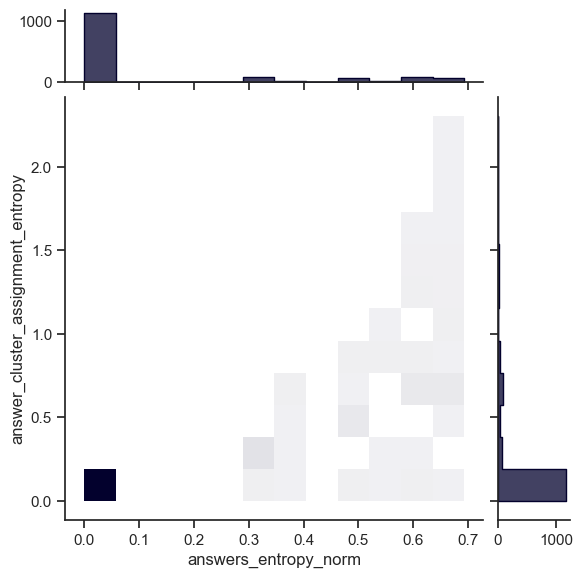

In [113]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answers_entropy_norm', y='answer_cluster_assignment_entropy', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

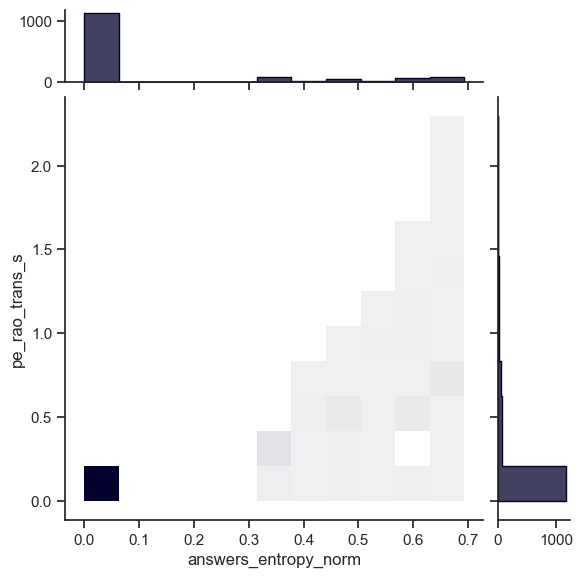

In [139]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answers_entropy_norm', y='pe_rao_trans_s', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False, bins=aggrodue["correct_mean"].nunique()
)

g.plot_marginals(sns.histplot, element="step", color="#03012d", bins=aggrodue["correct_mean"].nunique())

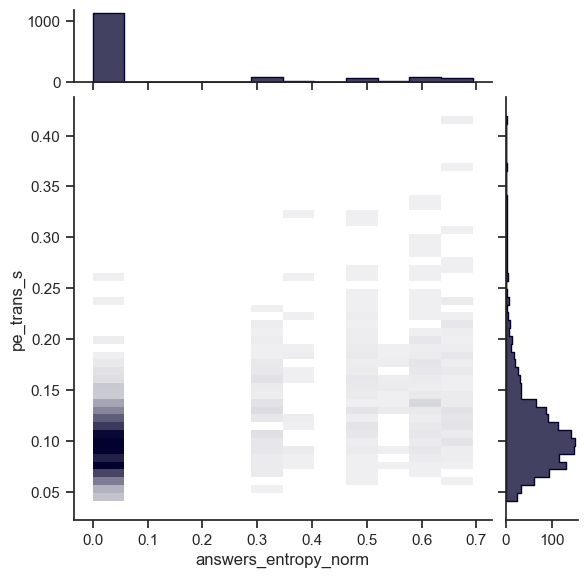

In [140]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answers_entropy_norm', y='pe_trans_s', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

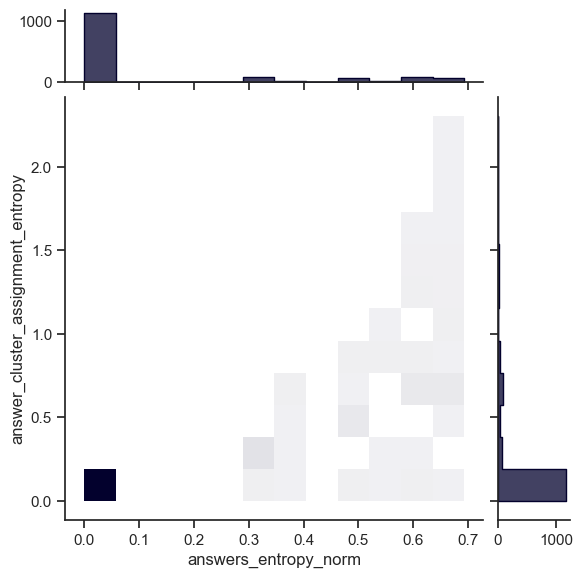

In [141]:

import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answers_entropy_norm', y='answer_cluster_assignment_entropy', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

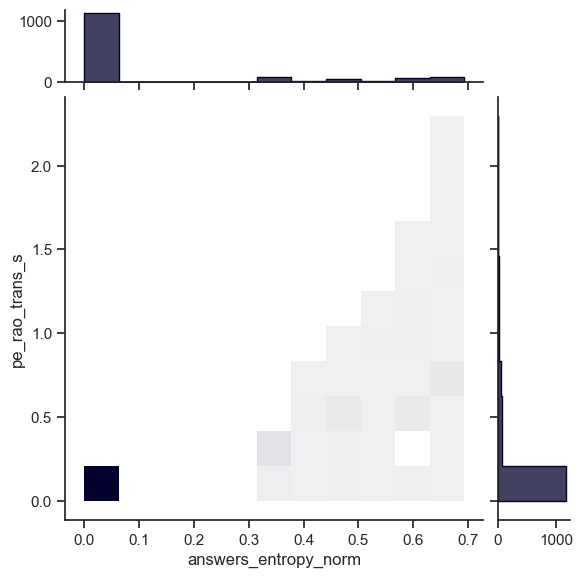

In [142]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answers_entropy_norm', y='pe_rao_trans_s', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False, bins=aggrodue["correct_mean"].nunique()
)

g.plot_marginals(sns.histplot, element="step", color="#03012d", bins=aggrodue["correct_mean"].nunique())

In [178]:
if True:
    with open('aggrodue.pickle', 'wb') as handle:
        pickle.dump(aggrodue, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!ls -larth aggrodue.pickle

### analysis

In [ ]:
# with open('aggrodue.deberta-v2-xxlarge.pickle', 'rb') as handle:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

<Axes: >

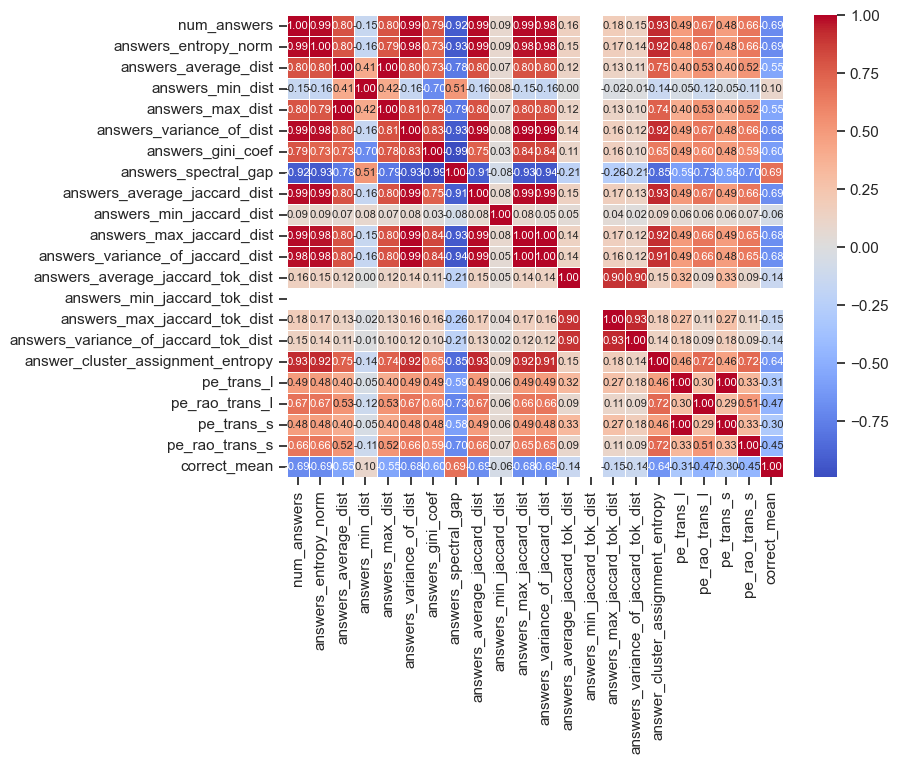

In [118]:
# correlazioni tra variabilità dell'output e accuracy

corr_matrix = aggrodue[['num_answers', 
                     'answers_entropy_norm', 
                     'answers_average_dist',
                     'answers_min_dist',
                     'answers_max_dist',
                     'answers_variance_of_dist',
                     'answers_gini_coef',
                     'answers_spectral_gap',
                     'answers_average_jaccard_dist',
                     'answers_min_jaccard_dist',
                     'answers_max_jaccard_dist',
                     'answers_variance_of_jaccard_dist',
                     'answers_average_jaccard_tok_dist',
                     'answers_min_jaccard_tok_dist',
                     'answers_max_jaccard_tok_dist',
                     'answers_variance_of_jaccard_tok_dist',
                     'answer_cluster_assignment_entropy',
                     'pe_trans_l', 'pe_rao_trans_l',
                     'pe_trans_s', 'pe_rao_trans_s',
                     'correct_mean']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 8})

<Axes: >

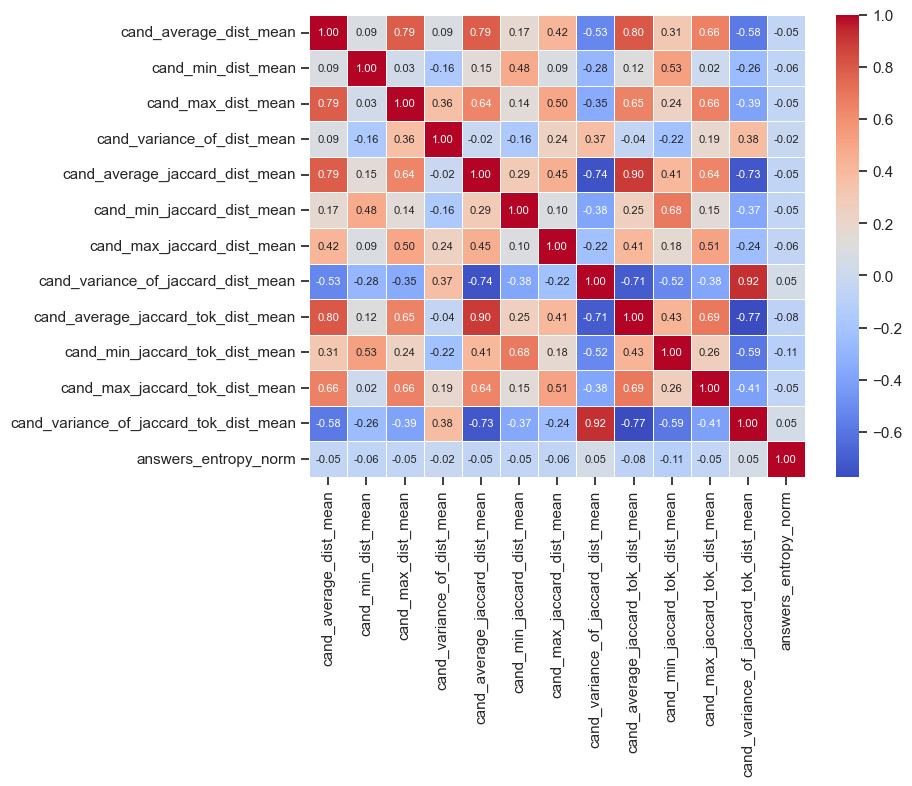

In [119]:
# correlazioni tra variabilità dell'output e accuracy

corr_matrix = aggrodue[['cand_average_dist_mean',
                     'cand_min_dist_mean',
                     'cand_max_dist_mean',
                     'cand_variance_of_dist_mean',
                     'cand_average_jaccard_dist_mean',
                     'cand_min_jaccard_dist_mean',
                     'cand_max_jaccard_dist_mean',
                     'cand_variance_of_jaccard_dist_mean',
                     'cand_average_jaccard_tok_dist_mean',
                     'cand_min_jaccard_tok_dist_mean',
                     'cand_max_jaccard_tok_dist_mean',
                     'cand_variance_of_jaccard_tok_dist_mean',
                     'answers_entropy_norm']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 8})

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_24442/3388410830.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])


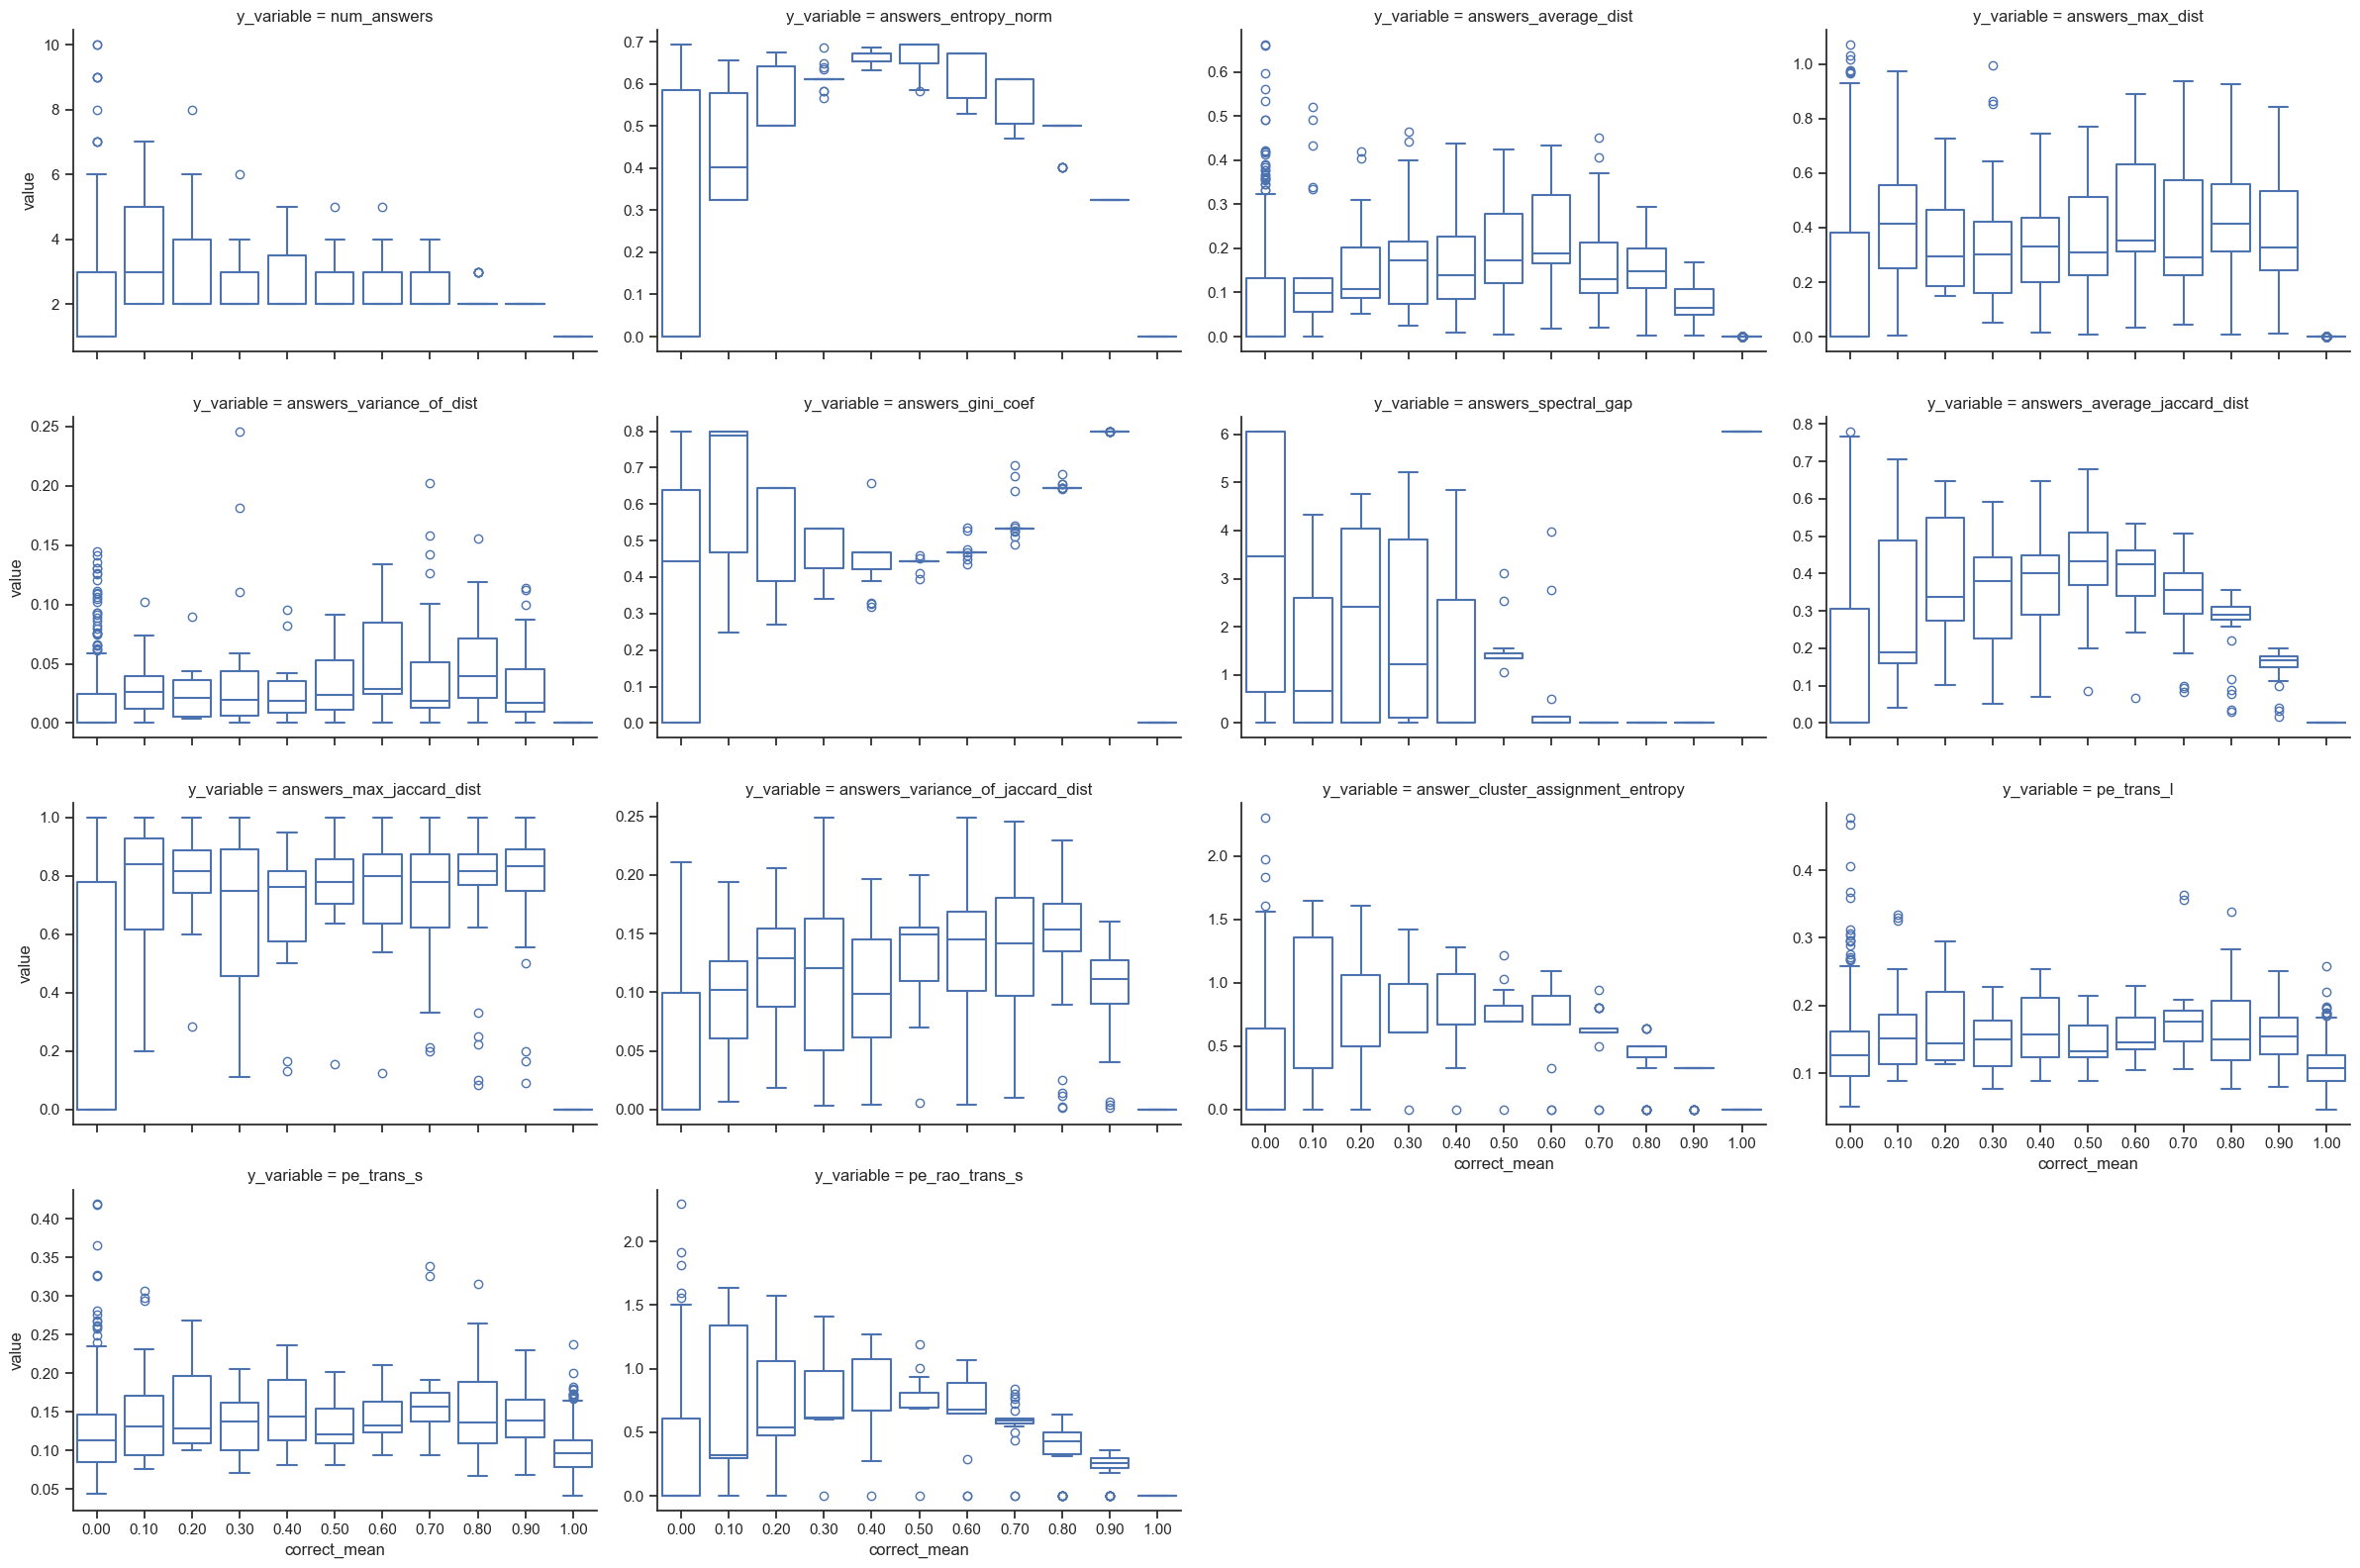

In [120]:

y_vars = ['num_answers', 
          'answers_entropy_norm', 
          'answers_average_dist', 
          'answers_max_dist',
          'answers_variance_of_dist',
          'answers_gini_coef',
          'answers_spectral_gap',
          'answers_average_jaccard_dist',
          'answers_max_jaccard_dist',
          'answers_variance_of_jaccard_dist',
          'answer_cluster_assignment_entropy',
          'pe_trans_l',
          'pe_trans_s',
          'pe_rao_trans_s']

# Reshape DataFrame to long format using `melt`
aggro_melted = aggrodue.melt(id_vars=["correct_mean"], value_vars=y_vars, 
                          var_name="y_variable", value_name="value")

# Create FacetGrid for multiple y-variables
g = sns.FacetGrid(aggro_melted, col="y_variable", height=4, aspect=1.5, sharex=True, sharey=False, col_wrap=4)

# Map violin plot to each facet
# g.map_dataframe(sns.violinplot, x="correct_mean", y="value", split=True, fill=False, inner="quart")
g.map_dataframe(sns.boxplot, x="correct_mean", y="value", fill=False)

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.2f}"))
    ax.set_xticklabels([f"{tick:.2f}" for tick in sorted(aggro_melted["correct_mean"].unique())])

In [121]:
aggrodue.correct_mean.value_counts()

correct_mean
1.0    978
0.0    282
0.9     52
0.8     35
0.7     25
0.1     21
0.3     19
0.6     17
0.4     15
0.2     15
0.5     11
Name: count, dtype: int64

In [122]:
# safety check
# aggrodue[(aggrodue.answers_entropy_norm<0.4) & (aggrodue.correct_mean<0.85) & (aggrodue.correct_mean>0.15)]

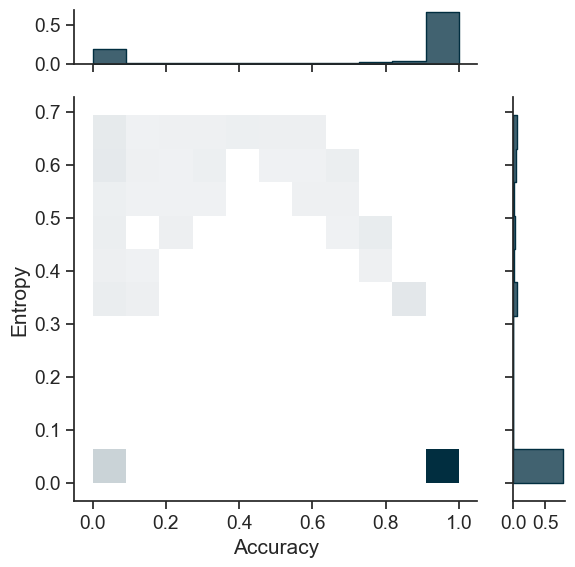

In [147]:
import seaborn as sns
from matplotlib.colors import to_rgba

sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.25)


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_entropy_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False,
    bins=aggrodue["correct_mean"].nunique()
)

g.plot_marginals(sns.histplot, element="step", color="#012E40", stat="probability", bins=aggrodue["correct_mean"].nunique())

# g.fig.suptitle("Average accuracy VS answer entropy " + model_name_short)
# g.fig.text(0.5, -0.05, model_name_short, ha='center')
# g.fig.suptitle(model_name_short)
g.set_axis_labels("Accuracy", "Entropy")

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

from matplotlib.patches import Rectangle
from palettable.tableau import TrafficLight_9
palette = TrafficLight_9.mpl_colors

plt.savefig("accuracy_vs_entropy_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

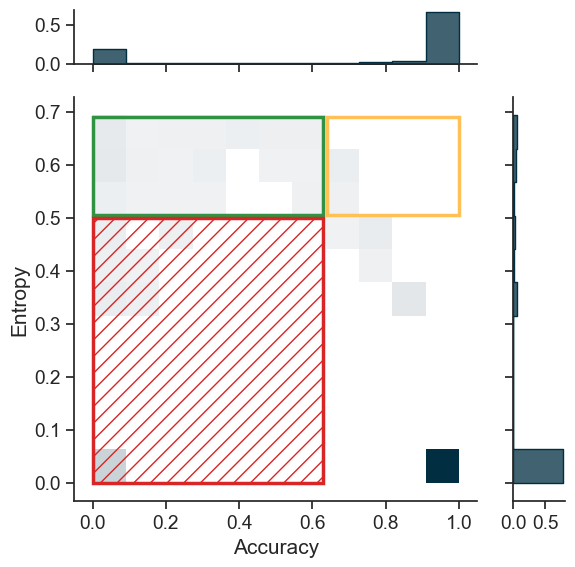

In [148]:
import seaborn as sns
from matplotlib.colors import to_rgba

sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.25)


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_entropy_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False,
    bins=aggrodue["correct_mean"].nunique()
)

g.plot_marginals(sns.histplot, element="step", color="#012E40", stat="probability", bins=aggrodue["correct_mean"].nunique())

g.set_axis_labels("Accuracy", "Entropy")

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

from matplotlib.patches import Rectangle
from palettable.tableau import TrafficLight_9
palette = TrafficLight_9.mpl_colors

g.ax_joint.add_patch(
        Rectangle(
            (0.63, 0.69), -0.63, -0.185,
            linewidth=2.5,
            edgecolor=palette[2],
            facecolor=to_rgba(palette[2], alpha=0.)
        )
    )
g.ax_joint.add_patch(
        Rectangle(
            (0.64, 0.69), 0.36, -0.185,
            linewidth=2.5,
            edgecolor=palette[4],
            facecolor=to_rgba(palette[4], alpha=0.)
        )
    )

g.ax_joint.add_patch(
        Rectangle(
            (0.63, 0.499), -0.63, -0.499,
            linewidth=2.5,
            edgecolor=palette[3],
            facecolor=to_rgba(palette[3], alpha=0.),
            hatch='//'
        )
    )

plt.savefig("accuracy_vs_entropy_squares_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

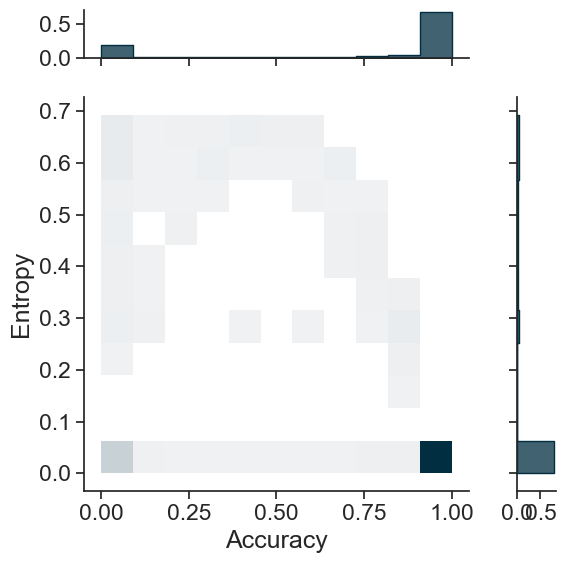

In [125]:
import seaborn as sns
from matplotlib.colors import to_rgba

sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.5)


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='pe_rao_trans_s_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False,
    bins=aggrodue["correct_mean"].nunique()
)

g.plot_marginals(sns.histplot, element="step", color="#012E40", stat="probability", bins=aggrodue["correct_mean"].nunique())

# g.fig.suptitle("Average accuracy VS answer entropy " + model_name_short)
# g.fig.text(0.5, -0.05, model_name_short, ha='center')
# g.fig.suptitle(model_name_short)
g.set_axis_labels("Accuracy", "Entropy")

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

from matplotlib.patches import Rectangle
from palettable.tableau import TrafficLight_9
palette = TrafficLight_9.mpl_colors

plt.savefig("accuracy_vs_se_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

In [126]:
aggrodue

,pid,answer_clean,answer_clean_embedding,answer_seq0,cand_clean,right_answer_clean_embedding,cos_sim_right_and_answers,right_and_answers_avg_dist,right_and_answers_mindist,answers_average_dist,answers_min_dist,answers_max_dist,answers_variance_of_dist,answers_gini_coef,answers_spectral_gap,num_answers,answers_average_jaccard_dist,answers_min_jaccard_dist,answers_max_jaccard_dist,answers_variance_of_jaccard_dist,answers_average_jaccard_tok_dist,answers_min_jaccard_tok_dist,answers_max_jaccard_tok_dist,answers_variance_of_jaccard_tok_dist,answers_freqs,answers_entropy,answers_entropy_norm,start,answer_seq0_clean,correct_mean,right_cand_avg_dist_mean,right_cand_avg_dist_std,right_cand_mindist_mean,right_cand_mindist_std,cand_variance_of_dist_mean,cand_variance_of_dist_std,cand_gini_coef_mean,cand_gini_coef_std,cand_spectral_gap_mean,cand_spectral_gap_std,cand_average_dist_mean,cand_average_dist_std,cand_min_dist_mean,cand_min_dist_std,cand_max_dist_mean,cand_max_dist_std,cand_average_jaccard_dist_mean,cand_average_jaccard_dist_std,cand_min_jaccard_dist_mean,cand_min_jaccard_dist_std,cand_max_jaccard_dist_mean,cand_max_jaccard_dist_std,cand_variance_of_jaccard_dist_mean,cand_variance_of_jaccard_dist_std,cand_average_jaccard_tok_dist_mean,cand_average_jaccard_tok_dist_std,cand_min_jaccard_tok_dist_mean,cand_min_jaccard_tok_dist_std,cand_max_jaccard_tok_dist_mean,cand_max_jaccard_tok_dist_std,cand_variance_of_jaccard_tok_dist_mean,cand_variance_of_jaccard_tok_dist_std,trans_l,trans_s,answer_semantic_ids,answer_cluster_assignment_entropy,pe_trans_l,pe_rao_trans_l,pe_trans_s,pe_rao_trans_s,num_sem_clust,pe_rao_trans_s_norm,pe_rao_trans_l_norm,answer_cluster_assignment_entropy_norm
0,0,"[kelana jaya lrt station railway station elevated station, kelana jaya lrt station railway station elevated station, kelana ...","[[-0.018287627, -0.046753973, 0.00044805135, 0.017965578, 0.01064477, -0.019449834, 0.03585343, 0.008647276, -0.016140312, 0...","[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476...","[murni discovery kelana jaya restaurant in petaling, selangor, malaysia restaurant, templat:s-line/rel rapidkl right/laluan ...","[[-0.0042959745, -0.06554798, -0.0039079664, -0.008474352, 0.01506154, 0.0069158627, 0.0626388, 0.014095148, 0.00012381196, ...","[0.5172461867332458, 0.5172461867332458, 0.5172461867332458, 0.5172461867332458, 0.5172461867332458, 0.5172461867332458, 0.5...",5.363931e-01,4.827538e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,1,0.000000,0.0,0.0,0.000000,0.002198,0.0,0.004938,2.771626e-06,[10],0.000000,0.000000,1646,"[[108, 235322, 41053, 1577, 92136, 208048, 7148, 892, 48578, 235307, 25487, 7148, 892, 9321, 235307, 32518, 7148, 235313, 23...",0.0,0.538844,0.0,0.239088,0.0,0.017280,0.0,0.139516,0.0,22.013813,0.0,0.527932,0.0,0.029305,0.0,0.865894,0.0,0.811374,0.0,0.230769,0.0,0.96,0.0,0.015092,0.0,0.789933,0.0,0.235294,0.0,0.942857,0.0,0.013646,0.0,"[[-0.15356723964214325, -0.027996260672807693, -0.036367736756801605, -4.9828242481453344e-05, -7.176141662057489e-05, -0.05...","[[-0.11282224208116531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.504690825939...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-0.0,0.131672,-0.000000e+00,0.115193,-0.000000e+00,1,-0.000000e+00,-0.000000e+00,-0.0
1,1,"[eritrea country in the horn of africa sovereign state, eritrea country in the horn of africa sovereign state, eritrea count...","[[0.05808096, -0.047776856, -0.047917187, 0.013630325, -0.029806854, -0.0019809448, 0.04399012, -0.012156454, 0.057320103, 4...","[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476...","[nakfa currency of eritrea currency, coastal eritrea none none, template:regions of eritrea wikimedia template wikimedia tem...","[[0.05808096, -0.047776856, -0.047917187, 0.013630325, -0.029806854, -0.0019809448, 0.04399012, -0

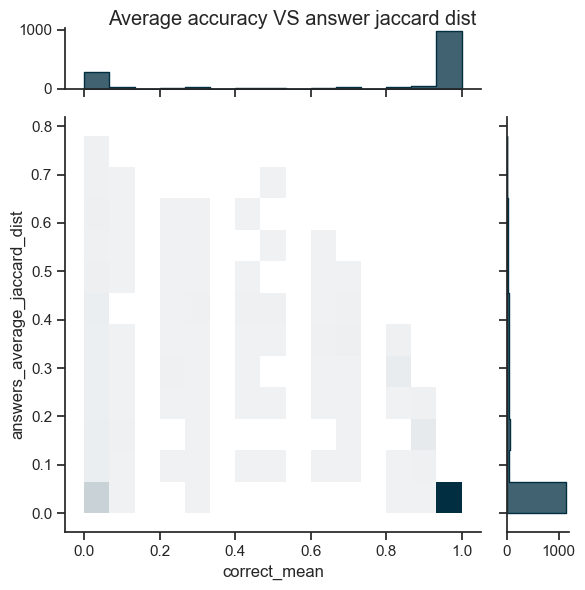

In [127]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='answers_average_jaccard_dist', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer jaccard dist")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

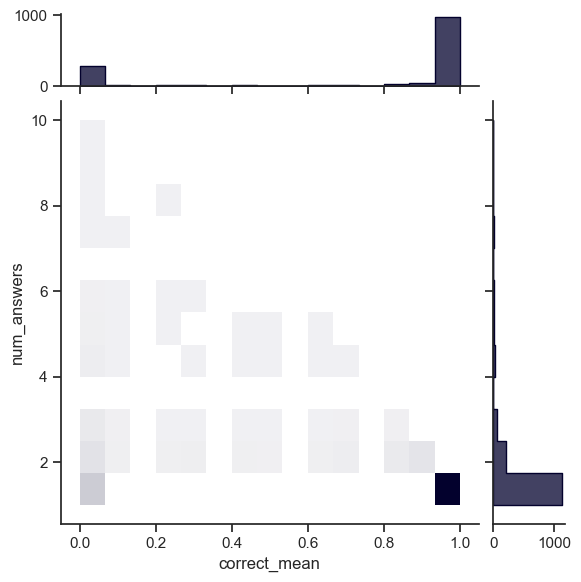

In [128]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='correct_mean', y='num_answers', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

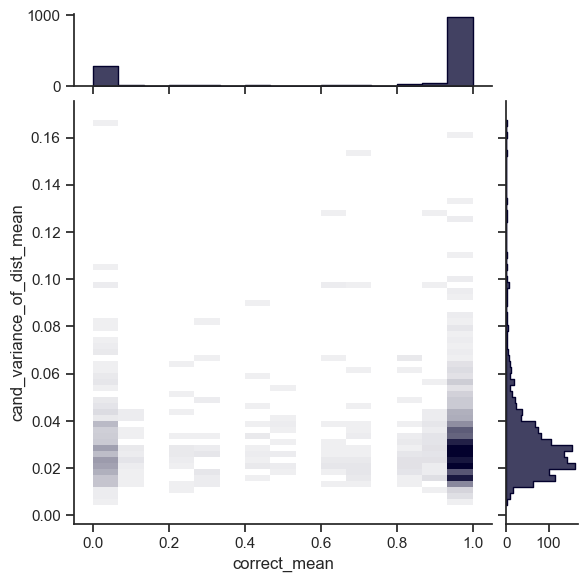

In [129]:

import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, y='cand_variance_of_dist_mean', x='correct_mean', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")

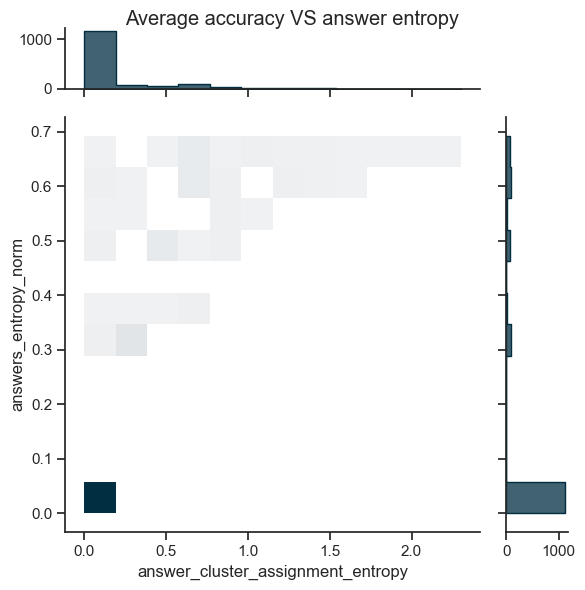

In [130]:
import seaborn as sns
sns.set_theme(style="ticks")


g = sns.JointGrid(data=aggrodue, x='answer_cluster_assignment_entropy', y='answers_entropy_norm', marginal_ticks=True)

g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#012E40", cbar=False
)

g.plot_marginals(sns.histplot, element="step", color="#012E40")

g.fig.suptitle("Average accuracy VS answer entropy")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)